<a href="https://colab.research.google.com/github/eisbetterthanpi/Autoencoder/blob/main/VQ_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title gdown
import pickle
!gdown 1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY -O buffer512.pkl # S
with open('buffer512.pkl', 'rb') as f: buffer = pickle.load(f)

Downloading...
From (original): https://drive.google.com/uc?id=1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY
From (redirected): https://drive.google.com/uc?id=1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY&confirm=t&uuid=eb3212e4-afe4-42ac-8edc-219e8b193871
To: /content/buffer512.pkl
100% 706M/706M [00:13<00:00, 50.9MB/s]


In [ ]:
# @title buffer dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# import faiss
import random
import torchvision
import torch.nn.functional as F
import numpy as np

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, buffer, seq_len):
        self.data = [step for episode in buffer for step in episode] # 0.00053
        self.seq_len = seq_len
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, action, reward = self.data[idx]
        state = self.transform(state)
        return state

    def add(self, episode):
        self.data.append(episode)

from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(3, 3))
    # print(npimg.shape) # (3, 64, 64)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


seq_len = 50 # 50
train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
from torch.utils.data.dataloader import DataLoader
batch_size = 128 # 128 512
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4

# train_data.data = train_data.data + episode


In [ ]:
# @title FSQ me
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def ste_round(x): return x.round().detach() + x - x.detach()

class FSQ(nn.Module):
    def __init__(self, levels):
        super().__init__()
        self.levels = torch.tensor(levels, device=device)
        self.basis = torch.cumprod(torch.tensor([*levels[1:], 1], device=device).flip(-1), dim=0).flip(-1)
        self.half_width = (self.levels-1)/2
        self.codebook_size = torch.prod(self.levels).item()
        self.codebook = self.indexes_to_codes(torch.arange(self.codebook_size, device=device))

    def forward(self, z, beta=1): # beta in (0,1). beta->0 => values more spread out
        offset = (self.levels+1) % 2 /2 # .5 if even, 0 if odd
        bound = (F.sigmoid(z)-1/2) * (self.levels-beta) + offset
        # print('fwd', bound) #
        quantized = ste_round(bound)
        # print('fwd', quantized) # 4: -1012
        return (quantized-offset) / self.half_width # split [-1,1]

    def codes_to_indexes(self, zhat):
        zhat = (zhat + 1) * self.half_width
        return (zhat * self.basis).sum(axis=-1)#.int()

    def indexes_to_codes(self, indices):
        indices = indices.unsqueeze(-1)
        codes = torch.remainder(indices//self.basis, self.levels)
        # print("codes",codes)
        return codes / self.half_width - 1

fsq = FSQ(levels = [5,4,3,2])
# print(fsq.codebook)
batch_size, seq_len = 2, 4
# x = torch.rand((batch_size, seq_len,3),device=device)
x = torch.linspace(-2,2,7, device=device).repeat(4,1).T
la = fsq(x)
print(la)
lact = fsq.codes_to_indexes(la)
print(lact)
# la = fsq.indexes_to_codes(lact)
# print(la)


In [ ]:
# @title UIB
class UIB(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=3, mult=4):
        super().__init__()
        act = nn.SiLU()
        out_ch = out_ch or in_ch
        # self.gamma = nn.Parameter(1e-5 * torch.ones(out_ch, 1, 1))
        # if self.r==1: self.conv = nn.Sequential( # og
        # self.conv = nn.Sequential( # og
        #     nn.Conv2d(in_ch, in_ch, kernel, 1, kernel//2, groups=in_ch, bias=False), nn.BatchNorm2d(in_ch),
        #     nn.Conv2d(in_ch, mult*in_ch, 1, bias=False), nn.BatchNorm2d(mult*in_ch), act,
        #     nn.Conv2d(mult*in_ch, mult*in_ch, kernel, 1, kernel//2, groups=mult*in_ch, bias=False), nn.BatchNorm2d(mult*in_ch), act,
        #     nn.Conv2d(mult*in_ch, out_ch, 1, bias=False), nn.BatchNorm2d(out_ch),
        # )

        self.conv = nn.Sequential( # norm,act,conv
            nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, in_ch, kernel, 1, kernel//2, groups=in_ch, bias=False),
            nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, mult*in_ch, 1, bias=False),
            nn.BatchNorm2d(mult*in_ch), act, nn.Conv2d(mult*in_ch, mult*in_ch, kernel, 1, kernel//2, groups=mult*in_ch, bias=False),
            nn.BatchNorm2d(mult*in_ch), act, zero_module(nn.Conv2d(mult*in_ch, out_ch, 1, bias=False)),
        )

    def forward(self,x):
        return self.conv(x) #* self.gamma

# in_ch, out_ch = 16,3
in_ch, out_ch = 3,16
model = UIB(in_ch, out_ch, r=1/2)
# model = UIB(in_ch, out_ch, r=2)
x = torch.rand(128, in_ch, 64, 64)
out = model(x)
print(out.shape)
# print(out)


torch.Size([128, 16, 64, 64])


In [ ]:
# @title ResBlock
import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, emb_dim=None, drop=0.):
        super().__init__()
        if out_ch==None: out_ch=in_ch
        act = nn.SiLU() #
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        # self.res_conv = zero_module(nn.Conv2d(in_ch, out_ch, 1)) if in_ch != out_ch else nn.Identity()

        # self.block = nn.Sequential( # best?
        #     nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), act,
        #     zero_module(nn.Conv2d(out_ch, out_ch, 3, padding=1)), nn.BatchNorm2d(out_ch), act,
        #     )
        self.block = nn.Sequential(
            nn.BatchNorm2d(out_ch), act, nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), act, zero_module(nn.Conv2d(out_ch, out_ch, 3, padding=1)),
            )

    def forward(self, x, emb=None): # [b,c,h,w], [batch, emb_dim]
        return self.block(x) + self.res_conv(x)


In [ ]:
# @title UpDownBlock_me
import torch
import torch.nn as nn
import torch.nn.functional as F

class PixelShuffleConv(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=3, r=1):
        super().__init__()
        self.r = r
        r = max(r, int(1/r))
        out_ch = out_ch or in_ch
        # if self.r>1: self.net = nn.Sequential(nn.ConvTranspose2d(in_ch, out_ch, kernel, 2, kernel//2, output_padding=1))
        # if self.r>1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch*r**2, kernel, 1, kernel//2), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        if self.r>1: self.net = nn.Sequential(UIB(in_ch, out_ch*r**2, kernel), nn.PixelShuffle(r))
        # if self.r>1: self.net = nn.Sequential(ResBlock(in_ch, out_ch*r**2), nn.PixelShuffle(r))

        # elif self.r<1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel, 2, kernel//2))
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch*r**2, out_ch, kernel, 1, kernel//2)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), UIB(in_ch*r**2, out_ch, kernel))
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), ResBlock(in_ch*r**2, out_ch))

    def forward(self, x):
        return self.net(x)

class UpDownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, r=1, kernel=3):
        super().__init__()
        act = nn.SiLU()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_ch), act, PixelShuffleConv(in_ch, out_ch, kernel=kernel, r=r)
        )

    def forward(self, x): # [b,c,h,w]
        out = self.block(x)
        # shortcut = F.interpolate(x.unsqueeze(1), size=out.shape[1:], mode='nearest-exact').squeeze(1) # pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html
        shortcut = F.adaptive_avg_pool3d(x, out.shape[1:]) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        # shortcut = F.adaptive_max_pool3d(x, out.shape[1:]) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        # shortcut = F.adaptive_avg_pool3d(x, out.shape[1:]) if out.shape[1]>=x.shape[1] else F.adaptive_max_pool3d(x, out.shape[1:])
        return out + shortcut

# if out>in, inter=max=near. ave=ave
# if out<in, inter=ave. max=max

# in_ch, out_ch = 16,3
in_ch, out_ch = 3,16
# model = UpDownBlock(in_ch, out_ch, r=1/2).to(device)
model = UpDownBlock(in_ch, out_ch, r=2).to(device)

x = torch.rand(12, in_ch, 64,64, device=device)
out = model(x)

print(out.shape)


In [ ]:
# @title AttentionBlock
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

# class LayerNorm2d(nn.LayerNorm):
class LayerNorm2d(nn.RMSNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = super().forward(x)
        x = x.permute(0, 3, 1, 2)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads=None, d_head=8, cond_dim=None, dropout=0.): # .1
        super().__init__()
        self.d_model = d_model
        self.d_head = d_head
        self.n_heads = d_model // d_head
        # self.d_head = d_model // n_heads
        self.cond_dim = cond_dim
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.kv = nn.Linear(cond_dim or d_model, 2*d_model, bias=False)
        # self.k = nn.Sequential(nn.Dropout(dropout), nn.Linear(cond_dim, d_model, bias=False))
        self.lin = nn.Linear(d_model, d_model)
        # self.lin = zero_module(nn.Linear(d_model, d_model))
        # self.lin = nn.Sequential(nn.Dropout(dropout), zero_module(nn.Linear(d_model, d_model)))
        self.drop = nn.Dropout(dropout) # indp before q,k,v; after linout
        self.scale = self.d_head ** -.5

    def forward(self, x, cond=None, mask=None): # [batch, T, d_model]=[batch, h*w, c], [batch, num_tok, cond_dim], [batch,T]
        batch = x.shape[0]
        if self.cond_dim==None: cond=x # is self attn
        Q = self.q(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2) # [batch, T, d_model] -> [batch, n_heads, T, d_head]
        # K = self.k(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2)
        K, V = self.kv(cond).view(batch, -1, self.n_heads, 2*self.d_head).transpose(1, 2).chunk(2, dim=-1) # [batch, n_heads, T/num_tok, d_head]

        # # linear attention # Softmax(Q) @ (Softmax(K).T @ V)
        if mask != None:
            mask = mask[:, None, :, None] # [batch,T] -> [batch,1,T,1]
            K, V = K.masked_fill(mask, -torch.finfo(x.dtype).max), V.masked_fill(mask, -torch.finfo(x.dtype).max)
        Q, K = Q.softmax(dim=-1)*self.scale, K.softmax(dim=-2)
        context = K.transpose(-2,-1) @ V # [batch, n_heads, d_head, d_head]
        out = Q @ context # [batch, n_heads, T/num_tok, d_head]

        # # (quadratic) attention # Softmax(Q @ K.T) @ V
        # attn = Q @ K.transpose(-2,-1) * self.scale # [batch, n_heads, T] # [batch, n_heads, T, T/num_tok]
        # if mask != None: attn = attn.masked_fill(mask[:, None, :, None], -torch.finfo(attn.dtype).max) # [batch,T]->[batch,1,T,1]
        # attention = torch.softmax(attn, dim=-1)
        # out = self.drop(attention) @ V # [batch, n_heads, T, d_head]

        out = out.transpose(1, 2).flatten(2)
        return self.drop(self.lin(out)) # [batch, T, d_model]


class AttentionBlock(nn.Module):
    def __init__(self, d_model, d_head, cond_dim=None, mult=4, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.drop = nn.Dropout(dropout)
        self.cond_dim = cond_dim
        self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0) # 16448
        # self.self = Pooling()
        act = nn.GELU() # ReLU GELU
        # self.ff = nn.Sequential(
        #     *[nn.BatchNorm2d(d_model), act, SeparableConv2d(d_model, d_model),]*3
        #     )
        # self.ff = ResBlock(d_model) # 74112
        self.ff = UIB(d_model, mult=4) # uib m4 36992, m2 18944

    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        bchw = x.shape
        x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        # print('attnblk fwd',x.shape)

        # if self.cond_dim==None: cond=None # is self attn
        x = x + self.drop(self.self(self.norm(x)))
        x = x.transpose(1,2).reshape(*bchw)
        x = x + self.ff(x)
        # x = self.ff(x)
        # x = x + self.drop(self.norm2(self.ff(x)))
        return x

# pos_emb rope < learn < learned
# conv > pixel?
# droppath not required

# norm,act,conv < conv,norm,act
# 2*s1 < uib < resblock
# gatedadaln 3 < 2 = 1 < ffmult4 = 2*gatedadaln
# MaxPool2d(2,2) < MaxPool2d(3,2,3//2)


# dim = 64
# dim_head = 8
# heads = dim // dim_head
# model = AttentionBlock(d_model, d_head)
# # print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
# # print(images.shape) # [batch, 3, 32, 32]
# x = torch.rand(64, 3, 32, 32, device=device)
# # x = torch.rand(64, 3, 28,28, device=device)
# logits = model(x)
# print(logits.shape)



In [ ]:
# @title ae
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class VQVAE(nn.Module):
    def __init__(self, in_ch=3, d_model=16, out_ch=None, depth=4, num_res_blocks=1, n_head=-1, d_head=4):
        super().__init__()
        out_ch = out_ch or in_ch # z_channels z_dim
        # n_head = d_model // d_head
        mult = [1,1,1,1] # [1,2,3,4] [1,1,1,1] [1,2,2,2]
        ch_list = [d_model * m for m in mult] # [128, 256, 384, 512]
        self.encoder = nn.Sequential(
            UpDownBlock(3, ch_list[0], r=1/2),
            AttentionBlock(ch_list[0], d_head=4),
            UpDownBlock(ch_list[0], out_ch, r=1/2),
        )
        self.decoder = nn.Sequential(
            UpDownBlock(out_ch, ch_list[0], r=2),
            AttentionBlock(ch_list[0], d_head=4),
            UpDownBlock(ch_list[0], in_ch, r=2),
        )
        # self.vq = FSQ(levels = out_ch*[8])

    def forward(self, x):
        x = self.encoder(x)
        x = self.quantise(x)
        x = self.decoder(x)
        return x
    def encode(self, x):
        x = self.encoder(x)
        return self.quantise(x)
    def decode(self, x):
        x = self.quantise(x)
        return self.decoder(x)
    def quantise(self, x): # [b,c,h,w]->[b,h,w,c]->[b,c,h,w]
        # return self.vq(x.permute(0,2,3,1)).permute(0,3,1,2)
        return x

# split plateaus
# conv 3<7
# stride2 < pixel
# convres

batch=64
in_ch=3
z_dim=3
h,w = 64,64
model = VQVAE(in_ch, d_model=16, out_ch=z_dim, depth=4, num_res_blocks=1, n_head=-1, d_head=4).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683

x = torch.rand((batch, in_ch, h, w), device=device)
out = model.encode(x)
# print(out.shape)
# out = torch.rand((batch, in_ch, h, w), device=device)
x_ = model.decode(out)
# x = model.quantise(x)
print(x_.shape)
# # print(x)
# x_ = model(x)


43406
torch.Size([64, 3, 64, 64])


In [ ]:
# conv = nn.Conv2d(mid_channels*2, mid_channels*2, 3, 1, 3//2, groups=mid_channels*2)
# print(conv.weight.data.shape)
print(model.encoder[0].block[-1].net[-1].gamma)

In [ ]:
# @title VQVAE me

class VQVAE(nn.Module):
    def __init__(self, in_ch=3, d_model=16, out_ch=None, depth=4, num_res_blocks=1, n_head=-1, d_head=4):
        super().__init__()
        self.in_ch = in_ch
        self.d_model = d_model # base channel count for the model
        out_ch = out_ch or in_ch # z_channels z_dim
        # n_head = d_model // d_head
        # self.vq = VectorQuantizerEMA(num_emb=8192, emb_dim=out_ch, beta=0.5) # chat gpt
        # self.vq = FSQ(levels = z_dim*[32])

        mult = [1,1,1,1]
        # mult = [1,2,3,4] # [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in mult] # [128, 256, 384, 512]

        self.encoder = nn.Sequential(
            # nn.Conv2d(in_ch, ch_list[0], 3, 1, padding=3//2),

            ResBlock(in_ch, ch_list[0]),
            # ResBlock(ch_list[0], ch_list[1]),
            # ResBlock(ch_list[1], ch_list[1]),
            AttentionBlock(ch_list[0], d_head),

            # nn.PixelUnshuffle(2),
            # ResBlock(ch_list[0]*2**2, ch_list[1]),
            # nn.AvgPool2d(2,2),
            # nn.MaxPool2d(2,2),
            UpDownBlock(3, ch_list[0], r=1/2),

            ResBlock(ch_list[0], ch_list[1]),
            # ResBlock(ch_list[2], ch_list[2]),
            AttentionBlock(ch_list[1], d_head),
            # ResBlock(ch_list[1], ch_list[2]),

            # nn.PixelUnshuffle(2),
            # ResBlock(ch_list[2]*2**2, ch_list[3]),
            # nn.AvgPool2d(2,2),
            UpDownBlock(ch_list[0], out_ch, r=1/2),

            ResBlock(ch_list[2], ch_list[3]),
            AttentionBlock(ch_list[3], d_head),
            # ResBlock(ch_list[3], ch_list[3]),
            ResBlock(ch_list[3], out_ch),

            # # nn.GroupNorm(32, ch_list[-1]), nn.SiLU(), nn.Conv2d(ch_list[-1], out_ch, 3, 1, padding=3//2)
            # nn.BatchNorm2d(ch_list[-1]), nn.SiLU(), nn.Conv2d(ch_list[-1], out_ch, 3, 1, padding=3//2)
        )

        self.decoder = nn.Sequential(
            # nn.Conv2d(out_ch, ch_list[-1], 3, 1, padding=3//2),

            ResBlock(out_ch, ch_list[3]),
            # ResBlock(ch_list[3], ch_list[3]),
            AttentionBlock(ch_list[3], d_head),
            ResBlock(ch_list[3], ch_list[2]),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            UpDownBlock(out_ch, ch_list[0], r=2),

            # ResBlock(ch_list[3], ch_list[2]*2**2),
            # # AttentionBlock(ch_list[2]*2**2, d_head),
            # nn.PixelShuffle(2),

            ResBlock(ch_list[2], ch_list[1]),
            AttentionBlock(ch_list[2], d_head),
            # ResBlock(ch_list[1], ch_list[0]),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            UpDownBlock(ch_list[0], in_ch, r=2),
            # ResBlock(ch_list[1], ch_list[0]*2**2),
            # nn.PixelShuffle(2),

            ResBlock(ch_list[1], ch_list[0]),
            AttentionBlock(ch_list[0], d_head),
            ResBlock(ch_list[0], in_ch),

            # # nn.GroupNorm(32, ch_list[0]), nn.SiLU(), nn.Conv2d(ch_list[0], in_ch, 3, 1, padding=3//2)
            # nn.BatchNorm2d(ch_list[0]), nn.SiLU(), zero_module(nn.Conv2d(ch_list[0], in_ch, 3, 1, padding=3//2)) # zero
        )

    # def forward(self, x):
    #     x = self.encoder(x)
    #     # print(x.shape)
    #     commitment_loss, x, _ = self.vq(x)
    #     # print(x.shape)
    #     x = self.decoder(x)
    #     return x, commitment_loss

    # def encode(self, x):
    #     x = self.encoder(x)
    #     _, x, _ = self.vq(x)
    #     return x

    # def decode(self, x):
    #     _, x, _ = self.vq(x)
    #     return self.decoder(x)

    def forward(self, x):
        x = self.encoder(x)
        # x = self.quantise(x)
        # print(x.shape)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        # return self.quantise(x)
        return x
    def decode(self, x):
        # _, x, _ = self.vq(x)
        # x = self.quantise(x)
        return self.decoder(x)
    def quantise(self, x): # [b,c,h,w]->[b,h,w,c]->[b,c,h,w]
        return self.vq(x.permute(0,2,3,1)).permute(0,3,1,2)



batch=2
in_ch=3
z_dim=3
h,w = 64,64
model = VQVAE(in_ch, d_model=16, out_ch=z_dim, depth=4, num_res_blocks=1, n_head=-1, d_head=4).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683

x = torch.rand((batch, in_ch, h, w), device=device)
# out, _ = model(x)
# print(out.shape)
# x = model.quantise(x)
# print(x.shape)
# print(x)


In [ ]:
# @title mit-han-lab/efficientvit dc_ae.py down
# https://github.com/mit-han-lab/efficientvit/blob/master/efficientvit/models/efficientvit/dc_ae.py
import torch
import torch.nn as nn

class DCAE(nn.Module):
    def __init__(self, in_ch=3, out_ch=4, d_model=16, mult=[1], depth_list=[1,1]):
        super().__init__()
        width_list=[d_model*m for m in mult]
        # encoder mult=[1,2,4,4,8,8] # depth_list=[0,4,8,2,2,2]
        # decoder mult=[1,2,4,4,8,8] # depth_list=[0,5,10,2,2,2]

        self.encoder = nn.Sequential(
            nn.Conv2d(in_ch, width_list[0], 3, 2, padding=3//2),

            UpDownBlock(width_list[0], width_list[0], r=1/2),
            ResBlock(width_list[0]),
            UpDownBlock(width_list[0], width_list[-1], r=1/2),
            ResBlock(width_list[-1]),
            AttentionBlock(width_list[-1], d_head=4),
            UpDownBlock(width_list[-1], out_ch, r=1),
        )
        self.decoder = nn.Sequential(
            UpDownBlock(out_ch, width_list[-1], r=1),
            AttentionBlock(width_list[-1], d_head=4),
            ResBlock(width_list[-1]),
            UpDownBlock(width_list[-1], width_list[0], r=2),
            ResBlock(width_list[0]),
            nn.BatchNorm2d(width_list[0]), nn.ReLU(), UpDownBlock(width_list[0], width_list[0], r=2),
            nn.ConvTranspose2d(width_list[0], in_ch, 3, 2, padding=3//2, output_padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

in_ch=3
out_ch=3
# 3*2^2|d_model
model = DCAE(in_ch, out_ch, d_model=16, mult=[1,1], depth_list=[1,1]).to(device)
# print(sum(p.numel() for p in model.stages.parameters() if p.requires_grad)) # 4393984
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
x = torch.rand((2,in_ch,64,64), device=device)
sx = model.encoder(x)
print(sx.shape)
out = model.decoder(sx)
# out = model(x)
print(out.shape)


89100
torch.Size([2, 3, 8, 8])
torch.Size([2, 3, 64, 64])


0
0.15592649579048157
0.031037278473377228
0.02776416763663292
0.023351144045591354
0.01948333904147148


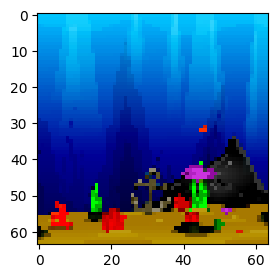

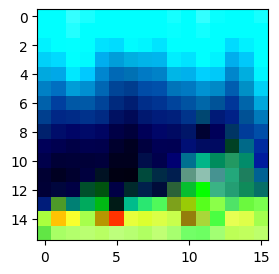

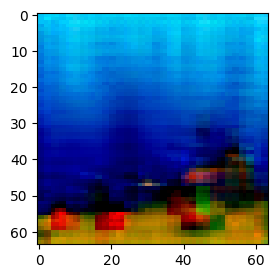

1
0.02046068012714386
0.018526192754507065
0.01667286828160286
0.016908854246139526
0.015017877332866192


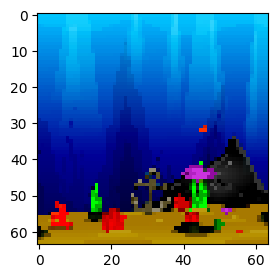

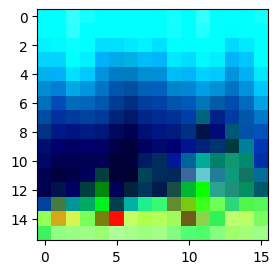

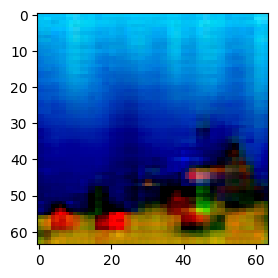

2
0.01577838324010372
0.014901185408234596
0.01437395066022873
0.013449309393763542
0.014475559815764427


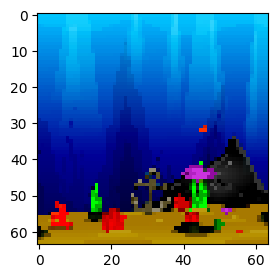

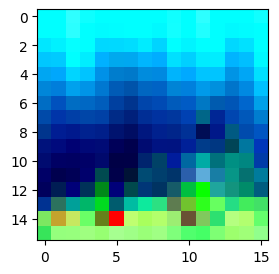

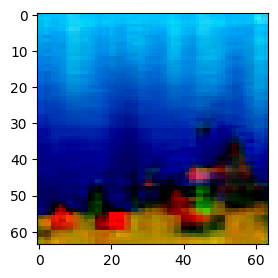

3
0.014214983209967613
0.013033712282776833
0.013248339295387268
0.013164873234927654
0.012004087679088116


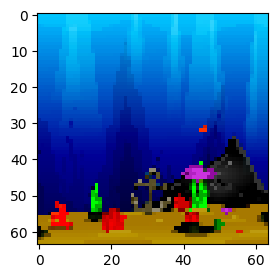

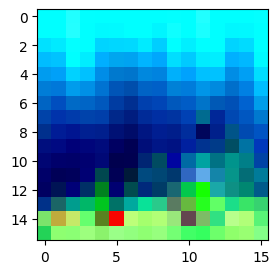

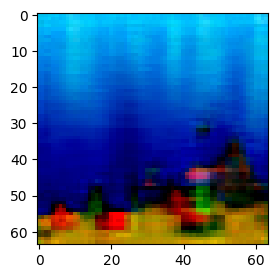

4
0.012780483812093735
0.011317635886371136
0.011648351326584816
0.011279994621872902
0.012750747613608837


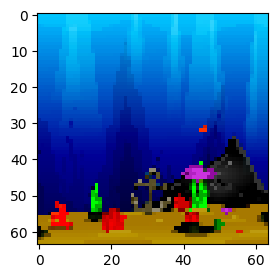

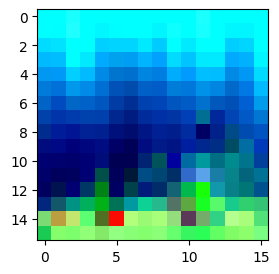

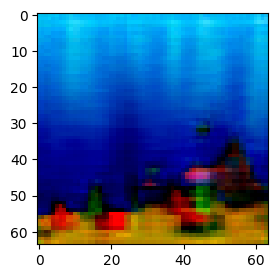

5
0.01087698619812727
0.012011177837848663
0.011059824377298355
0.011737453751266003
0.011077305302023888


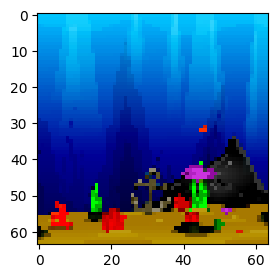

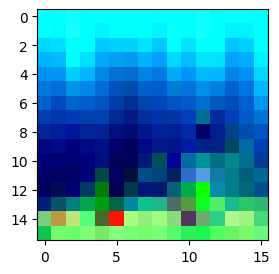

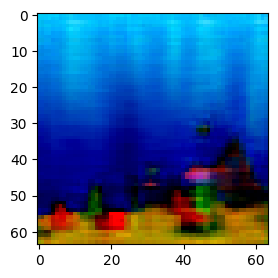

6
0.010294251143932343
0.010275756940245628
0.012437371537089348
0.010897304862737656
0.010672494769096375


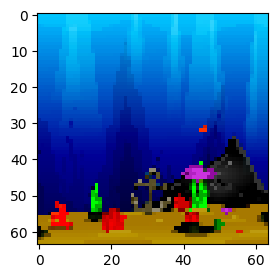

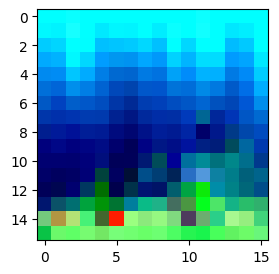

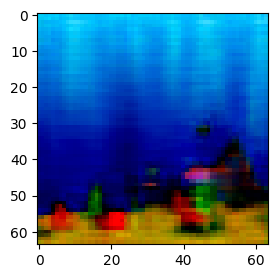

7
0.010114932432770729
0.010528250597417355
0.011046062223613262
0.0104288961738348
0.00995667651295662


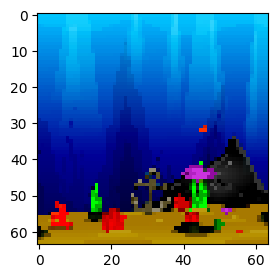

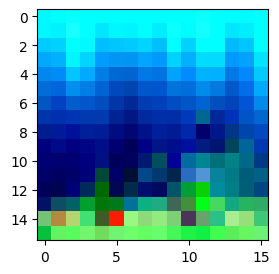

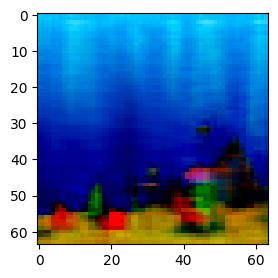

8
0.010221448726952076
0.010591047815978527
0.010694963857531548
0.010740363970398903
0.009355887770652771


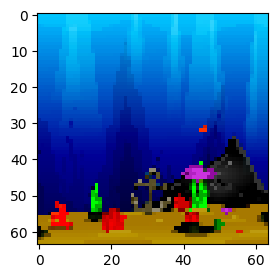

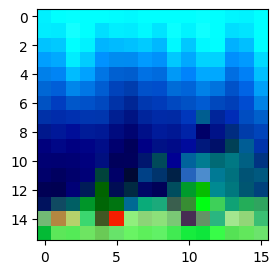

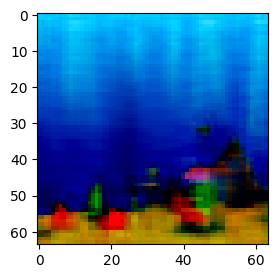

9
0.01004408672451973
0.00938483141362667
0.010746557265520096
0.00921991840004921
0.010741088539361954


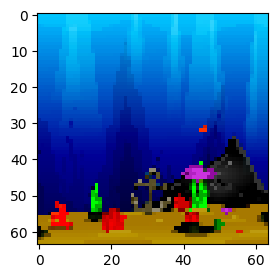

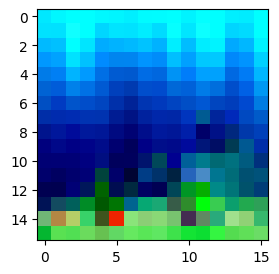

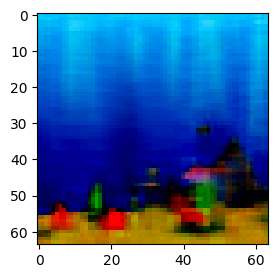

10
0.010120997205376625
0.009350322186946869
0.009853215888142586
0.009048735722899437
0.009306645020842552


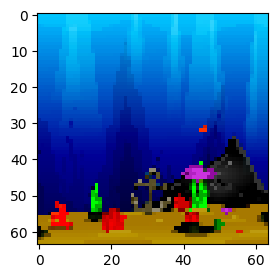

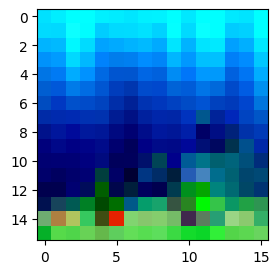

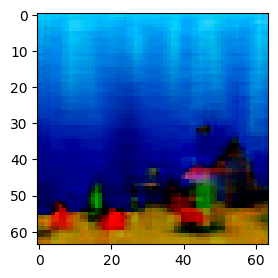

11
0.010184154845774174
0.009026924148201942
0.009683201089501381
0.008724039420485497
0.009610493667423725


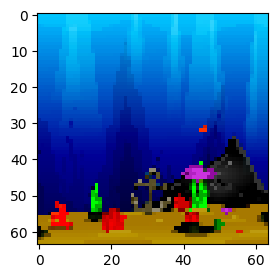

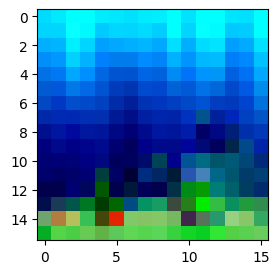

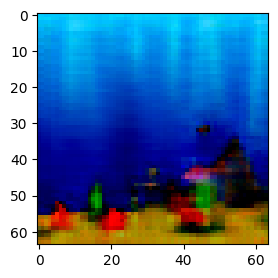

12
0.009458307176828384
0.009145203977823257


KeyboardInterrupt: 

In [ ]:
# @title train
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler(device)

def train(model, optim, dataloader, scheduler=None):
    model.train()
    # for i, (x, _) in enumerate(dataloader):
    for i, x in enumerate(dataloader):
        x = x.to(device)
        # x1 = F.interpolate(x1, size=(16,16)).repeat(1,3,1,1)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # float16 cannot?
            # x_, commitment_loss = model(x)
            # loss = commitment_loss + F.mse_loss(x, x_)

            x_ = model(x)
            loss = F.mse_loss(x, x_)
        optim.zero_grad()
        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # clip gradients
        scaler.step(optim)
        scaler.update()

        # if i%10 == 0:
            # with torch.no_grad():
            #     state = buffer[12][40][0]
            #     transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
            #     # transform = transforms.Compose([transforms.ToTensor()])
            #     x = transform(state).unsqueeze(0).to(device)#[0]
            #     out = model(x).squeeze(0)
            #     sx = model.encoder(x).squeeze(0)
            #     out = model.decoder(sx).squeeze(0)
            #     imshow(torchvision.utils.make_grid(sx.cpu()))
            #     imshow(torchvision.utils.make_grid(out.cpu()))

        if scheduler is not None: scheduler.step()
        try: wandb.log({"loss": loss.item()})
        except NameError: pass
        if i % 100 == 0: print(loss.item())


# for i in range(1):
for i in range(20): # 10
    print(i)
    train(model, optim, train_loader)

    model.eval()
    with torch.no_grad():
        # z = torch.randn(1,z_dim,8,8).to(device)
        # _, z, _ = model.vq(z)
        # z = model.quantise(z)

        # out = model.decode(z)
        # imshow(torchvision.utils.make_grid(out.cpu()))

        state = buffer[12][40][0]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # transform = transforms.Compose([transforms.ToTensor()])
        x = transform(state).unsqueeze(0).to(device)#[0]


        # out, _ = model(x)
        # out = model(x)
        sx = model.encoder(x)
        out = model.decoder(sx)
        imshow(torchvision.utils.make_grid(x.cpu()))
        imshow(torchvision.utils.make_grid(sx.cpu()))
        imshow(torchvision.utils.make_grid(out.cpu()))


In [ ]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="vqvae", config={"model": "res18",})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.02248


In [ ]:
# z = torch.randn(1,z_dim,16,16).to(device)
# with torch.no_grad(): out = model.decode(z)
# imshow(torchvision.utils.make_grid(out))

with torch.no_grad():
    state = buffer[12][40][0]
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # transform = transforms.Compose([transforms.ToTensor()])
    x = transform(state).unsqueeze(0).to(device)#[0]
    # out = model(x).squeeze(0)
    sx = model.encoder(x)#.squeeze(0)
    out = model.decoder(sx)#.squeeze(0)
    imshow(torchvision.utils.make_grid(sx.cpu()))
    imshow(torchvision.utils.make_grid(out.cpu()))

# out, _ = model(x)
# imshow(torchvision.utils.make_grid(out))

## drawer

In [ ]:
# @title data
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor(),])

# train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),)

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
batch_size = 64 # 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_loader) # get some random training images
# images, labels = next(dataiter)
# print(images.shape) # [batch, 3, 32, 32]
# imshow(torchvision.utils.make_grid(images))


In [ ]:
# @title chatgpt quantizer
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_emb, emb_dim, beta=0.5, decay=0.99):
        super().__init__()
        self.num_emb, self.emb_dim = num_emb, emb_dim
        self.beta, self.decay = beta, decay
        self.epsilon = 1e-5

        self.embeddings = nn.Parameter(torch.randn(num_emb, emb_dim))
        # self.embeddings = nn.Parameter(torch.randn(num_emb, emb_dim).uniform_(-3**.5, 3**.5))
        # self.embeddings = nn.Parameter(torch.randn(num_emb, emb_dim).uniform_(-1./num_emb, 1./num_emb))

        # Register buffers for EMA updates.
        self.register_buffer('ema_cluster_size', torch.zeros(num_emb))
        self.register_buffer('ema_w', self.embeddings.data.clone())
        # self.ema_cluster_size = nn.Parameter(torch.zeros(num_emb), requires_grad=False)
        # self.ema_w = nn.Parameter(self.embeddings.data.clone(), requires_grad=False)

    def forward(self, z):
        # Save the original shape and flatten the input to (batch_size * ..., emb_dim)
        input_shape = z.shape
        # flat_z = z.view(-1, self.emb_dim)

        # flat_z = z.flatten(2).transpose(1,2) # [b,h*w,c]
        flat_z = z.permute(0,2,3,1).flatten(end_dim=-2) # [b*h*w,c]
        # print(flat_z.shape)

        # distances = (torch.sum(flat_z ** 2, dim=1, keepdim=True) + torch.sum(self.embeddings ** 2, dim=1) - 2 * torch.matmul(flat_z, self.embeddings.t()))
        distances = (torch.sum(flat_z**2, dim=1, keepdim=True) + torch.sum(self.embeddings**2, dim=1) - 2*torch.matmul(flat_z, self.embeddings.T))
        enc_ind = torch.argmin(distances, dim=1)
        encs = F.one_hot(enc_ind, self.num_emb).type(flat_z.dtype)
        # Quantise the input by replacing with the nearest embedding.
        z_q = torch.matmul(encs, self.embeddings).view(input_shape)

        commitment_loss = self.beta * F.mse_loss(z_q.detach(), z) # commitment loss.
        # loss = self.beta * torch.mean((z_q.detach()-z)**2) + torch.mean((z_q-z.detach())**2) # comitment, codebook

        if self.training:
            # EMA update for cluster size.
            ema_cluster_size = torch.sum(encs, dim=0)
            self.ema_cluster_size = self.ema_cluster_size * self.decay + (1 - self.decay) * ema_cluster_size
            # Laplace smoothing to avoid zero counts.
            n = torch.sum(self.ema_cluster_size)
            self.ema_cluster_size = ((self.ema_cluster_size + self.epsilon) / (n + self.num_emb * self.epsilon)) * n

            # EMA update for the embedding weights.
            # dw = torch.matmul(encs.t(), flat_z)
            dw = encs.T @ flat_z.detach()
            # print('vq fwd', encs.T, flat_z)
            self.ema_w = self.ema_w * self.decay + (1 - self.decay) * dw

            # Update embeddings with the EMA values.
            self.embeddings.data = self.ema_w / self.ema_cluster_size.unsqueeze(1)

        # # Compute perplexity of the encs.
        # avg_probs = torch.mean(encs, dim=0)
        # perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + self.epsilon)))

        z_q = z + (z_q - z).detach()
        # print(z_q.shape)
        # flat_z = z.permute(0,2,3,1).flatten(end_dim=-2) # [b*h*w,c]

        # z_q = z_q.transpose(1,2).reshape(*bchw)
        # return loss, z_q, perplexity, enc_ind
        return commitment_loss, z_q, enc_ind

emb_dim, num_emb = 4,20
# x = torch.randn(2, 3, 4)
x = torch.randn(2, emb_dim, 5, 7)
vq = VectorQuantizerEMA(num_emb, emb_dim, beta=0.5) # chat gpt
loss, z_q, enc_ind = vq(x)
print(z_q.shape)
# print(out)


In [ ]:
# @title vqvae conv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class VQVAE(nn.Module):
    def __init__(self, in_ch=3, d_model=32, z_dim=3):
        super().__init__()
        d_list=[16, 3] # 849126
        act = nn.GELU() # ReLU GELU SiLU
        kernel = 3
        self.encoder = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            # nn.Conv2d(1, 16, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 14
            nn.Conv2d(in_ch, d_model, kernel, 2, kernel//2), nn.BatchNorm2d(d_model), act,# nn.MaxPool2d(2,2),
            nn.Conv2d(d_model, z_dim, kernel, 2, kernel//2), act
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, d_model, kernel, stride=2, padding=kernel//2, output_padding=1), nn.BatchNorm2d(d_model), act,
            # nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(d_model, in_ch, kernel, 2, padding=kernel//2, output_padding=1)
        )
        # self.vq = VectorQuantizerEMA(num_emb=20, emb_dim=z_dim, beta=0.5) # chat gpt
        self.vq = FSQ(levels = z_dim*[8])

    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        commitment_loss, quantised, encoding_indices = self.vq(x)
        # print(x.shape)
        x = self.decoder(quantised)
        return x, commitment_loss

    def forward(self, x):
        x = self.encoder(x)
        x = self.quantise(x)
        # print(x.shape)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        return self.quantise(x)
    def decode(self, x):
        # _, x, _ = self.vq(x)
        x = self.quantise(x)
        return self.decoder(x)
    def quantise(self, x): # [b,c,h,w]->[b,h,w,c]->[b,c,h,w]
        return self.vq(x.permute(0,2,3,1)).permute(0,3,1,2)


in_ch=3
d_model=32
z_dim=3
model = VQVAE(in_ch, d_model, z_dim).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 16x16 conv 17651 ; pixel(3)(3)  ; (1)(1)  ; (3,7,15)(3,7)  ; (3,5,7)(3,5) 42706 ; 7,5 70226

x = torch.randn((2, in_ch, 64, 64), device=device)
# out, _ = model(x)
out = model(x)
print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3)


In [ ]:
# @title vqvae from CompVis
# https://github.com/CompVis/stable-diffusion/blob/main/ldm/models/autoencoder.py
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
from contextlib import contextmanager

from ldm.modules.diffusionmodules.model import Encoder, Decoder
from ldm.modules.distributions.distributions import DiagonalGaussianDistribution

from ldm.util import instantiate_from_config


class VQModel(pl.LightningModule):
    def __init__(self,
                 ddconfig,
                 lossconfig,
                 n_embed,
                 embed_dim,
                 remap=None,
                 sane_index_shape=False, # tell vector quantizer to return indices as bhw
                 use_ema=False
                 ):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_embed = n_embed
        self.encoder = Encoder(**ddconfig)
        self.decoder = Decoder(**ddconfig)
        self.loss = instantiate_from_config(lossconfig)
        self.quantize = VectorQuantizer(n_embed, embed_dim, beta=0.25, remap=remap, sane_index_shape=sane_index_shape)
        self.quant_conv = torch.nn.Conv2d(ddconfig["z_channels"], embed_dim, 1)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"], 1)

        self.use_ema = use_ema
        if self.use_ema:
            self.model_ema = LitEma(self)
            print(f"Keeping EMAs of {len(list(self.model_ema.buffers()))}.")

    @contextmanager
    def ema_scope(self, context=None):
        if self.use_ema:
            self.model_ema.store(self.parameters())
            self.model_ema.copy_to(self)
            if context is not None:
                print(f"{context}: Switched to EMA weights")
        try:
            yield None
        finally:
            if self.use_ema:
                self.model_ema.restore(self.parameters())
                if context is not None:
                    print(f"{context}: Restored training weights")

    def on_train_batch_end(self, *args, **kwargs):
        if self.use_ema:
            self.model_ema(self)

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        quant, emb_loss, info = self.quantize(h)
        return quant, emb_loss, info

    def encode_to_prequant(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        return h

    def decode(self, quant):
        quant = self.post_quant_conv(quant)
        dec = self.decoder(quant)
        return dec

    def decode_code(self, code_b):
        quant_b = self.quantize.embed_code(code_b)
        dec = self.decode(quant_b)
        return dec

    def forward(self, input, return_pred_indices=False):
        quant, diff, (_,_,ind) = self.encode(input)
        dec = self.decode(quant)
        if return_pred_indices:
            return dec, diff, ind
        return dec, diff

    def get_input(self, batch, k):
        x = batch[k]
        if len(x.shape) == 3:
            x = x[..., None]
        x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format).float()
        return x

    def training_step(self, batch, batch_idx, optimizer_idx):
        # https://github.com/pytorch/pytorch/issues/37142
        # try not to fool the heuristics
        x = self.get_input(batch, self.image_key)
        xrec, qloss, ind = self(x, return_pred_indices=True)

        if optimizer_idx == 0:
            # autoencode
            aeloss, log_dict_ae = self.loss(qloss, x, xrec, optimizer_idx, self.global_step,
                                            last_layer=self.get_last_layer(), split="train",
                                            predicted_indices=ind)

            self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=True, on_epoch=True)
            return aeloss

        if optimizer_idx == 1:
            # discriminator
            discloss, log_dict_disc = self.loss(qloss, x, xrec, optimizer_idx, self.global_step, last_layer=self.get_last_layer(), split="train")
            self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=True, on_epoch=True)
            return discloss

    def validation_step(self, batch, batch_idx):
        log_dict = self._validation_step(batch, batch_idx)
        with self.ema_scope():
            log_dict_ema = self._validation_step(batch, batch_idx, suffix="_ema")
        return log_dict

    def _validation_step(self, batch, batch_idx, suffix=""):
        x = self.get_input(batch, self.image_key)
        xrec, qloss, ind = self(x, return_pred_indices=True)
        aeloss, log_dict_ae = self.loss(qloss, x, xrec, 0,
                                        self.global_step,
                                        last_layer=self.get_last_layer(),
                                        split="val"+suffix,
                                        predicted_indices=ind
                                        )

        discloss, log_dict_disc = self.loss(qloss, x, xrec, 1,
                                            self.global_step,
                                            last_layer=self.get_last_layer(),
                                            split="val"+suffix,
                                            predicted_indices=ind
                                            )
        rec_loss = log_dict_ae[f"val{suffix}/rec_loss"]
        self.log(f"val{suffix}/rec_loss", rec_loss,
                   prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log(f"val{suffix}/aeloss", aeloss,
                   prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)
        if version.parse(pl.__version__) >= version.parse('1.4.0'):
            del log_dict_ae[f"val{suffix}/rec_loss"]
        self.log_dict(log_dict_ae)
        self.log_dict(log_dict_disc)
        return self.log_dict

    def get_last_layer(self):
        return self.decoder.conv_out.weight


class VQModelInterface(VQModel):
    def __init__(self, embed_dim, *args, **kwargs):
        super().__init__(embed_dim=embed_dim, *args, **kwargs)
        self.embed_dim = embed_dim

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        return h

    def decode(self, h, force_not_quantize=False):
        # also go through quantization layer
        if not force_not_quantize:
            quant, emb_loss, info = self.quantize(h)
        else:
            quant = h
        quant = self.post_quant_conv(quant)
        dec = self.decoder(quant)
        return dec


class AutoencoderKL(pl.LightningModule):
    def __init__(self, ddconfig, lossconfig, embed_dim):
        super().__init__()
        self.encoder = Encoder(**ddconfig)
        self.decoder = Decoder(**ddconfig)
        self.loss = instantiate_from_config(lossconfig)
        assert ddconfig["double_z"]
        self.quant_conv = torch.nn.Conv2d(2*ddconfig["z_channels"], 2*embed_dim, 1)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"], 1)
        self.embed_dim = embed_dim


    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior

    def decode(self, z):
        z = self.post_quant_conv(z)
        dec = self.decoder(z)
        return dec

    def forward(self, input, sample_posterior=True):
        posterior = self.encode(input)
        if sample_posterior:
            z = posterior.sample()
        else:
            z = posterior.mode()
        dec = self.decode(z)
        return dec, posterior

    def get_input(self, batch, k):
        x = batch[k]
        if len(x.shape) == 3:
            x = x[..., None]
        x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format).float()
        return x

    def training_step(self, batch, batch_idx, optimizer_idx):
        inputs = self.get_input(batch, self.image_key)
        reconstructions, posterior = self(inputs)

        if optimizer_idx == 0:
            # train encoder+decoder+logvar
            aeloss, log_dict_ae = self.loss(inputs, reconstructions, posterior, optimizer_idx, self.global_step,
                                            last_layer=self.get_last_layer(), split="train")
            self.log("aeloss", aeloss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
            self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=True, on_epoch=False)
            return aeloss

        if optimizer_idx == 1:
            # train the discriminator
            discloss, log_dict_disc = self.loss(inputs, reconstructions, posterior, optimizer_idx, self.global_step, last_layer=self.get_last_layer(), split="train")

            self.log("discloss", discloss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
            self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=True, on_epoch=False)
            return discloss

    def validation_step(self, batch, batch_idx):
        inputs = self.get_input(batch, self.image_key)
        reconstructions, posterior = self(inputs)
        aeloss, log_dict_ae = self.loss(inputs, reconstructions, posterior, 0, self.global_step, last_layer=self.get_last_layer(), split="val")
        discloss, log_dict_disc = self.loss(inputs, reconstructions, posterior, 1, self.global_step, last_layer=self.get_last_layer(), split="val")

        self.log("val/rec_loss", log_dict_ae["val/rec_loss"])
        self.log_dict(log_dict_ae)
        self.log_dict(log_dict_disc)
        return self.log_dict

    def get_last_layer(self):
        return self.decoder.conv_out.weight


In [ ]:
# @title encoder from CompVis

# https://github.com/CompVis/stable-diffusion/blob/main/configs/latent-diffusion/cin-ldm-vq-f8.yaml
# ddconfig:
#     double_z: false
#     z_channels: 4
#     resolution: 256
#     in_channels: 3
#     out_ch: 3
#     ch: 128
#     ch_mult: 1,2,3,4
#     num_res_blocks: 2
#     attn_resolutions: 32

# https://github.com/CompVis/stable-diffusion/blob/main/configs/latent-diffusion/ffhq-ldm-vq-4.yaml
# https://github.com/CompVis/stable-diffusion/blob/main/configs/latent-diffusion/celebahq-ldm-vq-4.yaml
# embed_dim: 3
# n_embed: 8192 = 2^13 ~ 16^3
# ddconfig:
#   double_z: false
#   z_channels: 3
#   resolution: 256
#   in_channels: 3
#   out_ch: 3
#   ch: 128
#   ch_mult: 1,2,4
#   num_res_blocks: 2
#   attn_resolutions: []

class Encoder(nn.Module):
    def __init__(self, *, ch=128, out_ch=3, ch_mult=(1,2,3,4), num_res_blocks=2,
                 attn_resolutions=32, dropout=0.0, resamp_with_conv=True, in_channels=3,
                 resolution, z_channels, double_z=True, use_linear_attn=False, attn_type="vanilla",
                 **ignore_kwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels, self.ch, kernel_size=3, stride=1, padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+tuple(ch_mult) # 1,1,2,3,4
        self.in_ch_mult = in_ch_mult
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level] # 128 * 1,1,2,3,4
            block_out = ch*ch_mult[i_level] # 128 * 1,2,3,4
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in, out_channels=block_out, temb_channels=self.temb_ch, dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1: # downsample at all except last
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in, out_channels=block_in, temb_channels=self.temb_ch, dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in, out_channels=block_in, temb_channels=self.temb_ch, dropout=dropout)

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in, 2*z_channels if double_z else z_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # timestep embedding
        temb = None

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

encoder:
convin k3s1
res attn (),
norm act convout k3s1

self.conv_in = torch.nn.Conv2d(in_channels, self.ch, 3, 1, padding=3//2)

res res down res res down
res att res

self.conv_out = nn.Sequential(
    nn.GroupNorm(32, ch), nn.SiLU(), torch.nn.Conv2d(block_in, z_channels, 3, 1, padding=3//2)
)

me: down res res down res res
down res att down res att = lvl lvl

decoder:
conv_in
res att res
res res up res res up





In [ ]:
# @title CompVis model.py
# https://github.com/CompVis/stable-diffusion/blob/main/ldm/modules/diffusionmodules/model.py#L368

# pytorch_diffusion + derived encoder decoder
import math
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange

from ldm.util import instantiate_from_config
from ldm.modules.attention import LinearAttention


def get_timestep_embedding(timesteps, embedding_dim):
    """
    This matches the implementation in Denoising Diffusion Probabilistic Models:
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0,1,0,0))
    return emb


def nonlinearity(x):
    # swish
    return x*torch.sigmoid(x)


def Normalize(in_channels, num_groups=32):
    return torch.nn.GroupNorm(num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True)


class Upsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(x, scale_factor=2.0, mode="nearest")
        if self.with_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0,1,0,1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0)
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        if temb_channels > 0:
            self.temb_proj = torch.nn.Linear(temb_channels, out_channels)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, temb):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        if temb is not None:
            h = h + self.temb_proj(nonlinearity(temb))[:,:,None,None]

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h


class LinAttnBlock(LinearAttention):
    """to match AttnBlock usage"""
    def __init__(self, in_channels):
        super().__init__(dim=in_channels, heads=1, dim_head=in_channels)


class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)


    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b,c,h,w = q.shape
        q = q.reshape(b,c,h*w)
        q = q.permute(0,2,1)   # b,hw,c
        k = k.reshape(b,c,h*w) # b,c,hw
        w_ = torch.bmm(q,k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b,c,h*w)
        w_ = w_.permute(0,2,1)   # b,hw,hw (first hw of k, second of q)
        h_ = torch.bmm(v,w_)     # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = h_.reshape(b,c,h,w)

        h_ = self.proj_out(h_)

        return x+h_


def make_attn(in_channels, attn_type="vanilla"):
    assert attn_type in ["vanilla", "linear", "none"], f'attn_type {attn_type} unknown'
    print(f"making attention of type '{attn_type}' with {in_channels} in_channels")
    if attn_type == "vanilla":
        return AttnBlock(in_channels)
    elif attn_type == "none":
        return nn.Identity(in_channels)
    else:
        return LinAttnBlock(in_channels)


class Model(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, use_timestep=True, use_linear_attn=False, attn_type="vanilla"):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        self.use_timestep = use_timestep
        if self.use_timestep:
            # timestep embedding
            self.temb = nn.Module()
            self.temb.dense = nn.ModuleList([
                torch.nn.Linear(self.ch,
                                self.temb_ch),
                torch.nn.Linear(self.temb_ch,
                                self.temb_ch),
            ])

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+tuple(ch_mult)
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level]
                block.append(ResnetBlock(in_channels=block_in+skip_in, out_channels=block_out, temb_channels=self.temb_ch, dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up) # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in, out_ch, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t=None, context=None):
        #assert x.shape[2] == x.shape[3] == self.resolution
        if context is not None:
            # assume aligned context, cat along channel axis
            x = torch.cat((x, context), dim=1)
        if self.use_timestep:
            # timestep embedding
            assert t is not None
            temb = get_timestep_embedding(t, self.ch)
            temb = self.temb.dense[0](temb)
            temb = nonlinearity(temb)
            temb = self.temb.dense[1](temb)
        else:
            temb = None

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](
                    torch.cat([h, hs.pop()], dim=1), temb)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

    def get_last_layer(self):
        return self.conv_out.weight


class Encoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, double_z=True, use_linear_attn=False, attn_type="vanilla",
                 **ignore_kwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels, self.ch, kernel_size=3, stride=1, padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+tuple(ch_mult)
        self.in_ch_mult = in_ch_mult
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in, out_channels=block_out, temb_channels=self.temb_ch, dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in, out_channels=block_in, temb_channels=self.temb_ch, dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in, out_channels=block_in, temb_channels=self.temb_ch, dropout=dropout)

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in, 2*z_channels if double_z else z_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # timestep embedding
        temb = None

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h


class Decoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, give_pre_end=False, tanh_out=False, use_linear_attn=False,
                 attn_type="vanilla", **ignorekwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels
        self.give_pre_end = give_pre_end
        self.tanh_out = tanh_out

        # compute in_ch_mult, block_in and curr_res at lowest res
        in_ch_mult = (1,)+tuple(ch_mult)
        block_in = ch*ch_mult[self.num_resolutions-1]
        curr_res = resolution // 2**(self.num_resolutions-1)
        self.z_shape = (1,z_channels,curr_res,curr_res)
        print("Working with z of shape {} = {} dimensions.".format(self.z_shape, np.prod(self.z_shape)))

        # z to block_in
        self.conv_in = torch.nn.Conv2d(z_channels, block_in, kernel_size=3, stride=1, padding=1)
        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in, out_channels=block_in, temb_channels=self.temb_ch, dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in, out_channels=block_in, temb_channels=self.temb_ch, dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                block.append(ResnetBlock(in_channels=block_in, out_channels=block_out, temb_channels=self.temb_ch, dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up) # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in, out_ch, kernel_size=3, stride=1, padding=1)

    def forward(self, z):
        #assert z.shape[1:] == self.z_shape[1:]
        self.last_z_shape = z.shape

        # timestep embedding
        temb = None

        # z to block_in
        h = self.conv_in(z)

        # middle
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](h, temb)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        if self.give_pre_end:
            return h

        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        if self.tanh_out:
            h = torch.tanh(h)
        return h


class SimpleDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__()
        self.model = nn.ModuleList([nn.Conv2d(in_channels, in_channels, 1),
                                     ResnetBlock(in_channels=in_channels, out_channels=2 * in_channels, temb_channels=0, dropout=0.0),
                                     ResnetBlock(in_channels=2 * in_channels, out_channels=4 * in_channels, temb_channels=0, dropout=0.0),
                                     ResnetBlock(in_channels=4 * in_channels, out_channels=2 * in_channels, temb_channels=0, dropout=0.0),
                                     nn.Conv2d(2*in_channels, in_channels, 1),
                                     Upsample(in_channels, with_conv=True)])
        # end
        self.norm_out = Normalize(in_channels)
        self.conv_out = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        for i, layer in enumerate(self.model):
            if i in [1,2,3]:
                x = layer(x, None)
            else:
                x = layer(x)

        h = self.norm_out(x)
        h = nonlinearity(h)
        x = self.conv_out(h)
        return x


class UpsampleDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, ch, num_res_blocks, resolution,
                 ch_mult=(2,2), dropout=0.0):
        super().__init__()
        # upsampling
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        block_in = in_channels
        curr_res = resolution // 2 ** (self.num_resolutions - 1)
        self.res_blocks = nn.ModuleList()
        self.upsample_blocks = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            res_block = []
            block_out = ch * ch_mult[i_level]
            for i_block in range(self.num_res_blocks + 1):
                res_block.append(ResnetBlock(in_channels=block_in, out_channels=block_out, temb_channels=self.temb_ch, dropout=dropout))
                block_in = block_out
            self.res_blocks.append(nn.ModuleList(res_block))
            if i_level != self.num_resolutions - 1:
                self.upsample_blocks.append(Upsample(block_in, True))
                curr_res = curr_res * 2

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # upsampling
        h = x
        for k, i_level in enumerate(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks + 1):
                h = self.res_blocks[i_level][i_block](h, None)
            if i_level != self.num_resolutions - 1:
                h = self.upsample_blocks[k](h)
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h


class LatentRescaler(nn.Module):
    def __init__(self, factor, in_channels, mid_channels, out_channels, depth=2):
        super().__init__()
        # residual block, interpolate, residual block
        self.factor = factor
        self.conv_in = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.res_block1 = nn.ModuleList([ResnetBlock(in_channels=mid_channels, out_channels=mid_channels, temb_channels=0, dropout=0.0) for _ in range(depth)])
        self.attn = AttnBlock(mid_channels)
        self.res_block2 = nn.ModuleList([ResnetBlock(in_channels=mid_channels, out_channels=mid_channels, temb_channels=0, dropout=0.0) for _ in range(depth)])

        self.conv_out = nn.Conv2d(mid_channels, out_channels, kernel_size=1,)

    def forward(self, x):
        x = self.conv_in(x)
        for block in self.res_block1:
            x = block(x, None)
        x = torch.nn.functional.interpolate(x, size=(int(round(x.shape[2]*self.factor)), int(round(x.shape[3]*self.factor))))
        x = self.attn(x)
        for block in self.res_block2:
            x = block(x, None)
        x = self.conv_out(x)
        return x


class MergedRescaleEncoder(nn.Module):
    def __init__(self, in_channels, ch, resolution, out_ch, num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True,
                 ch_mult=(1,2,4,8), rescale_factor=1.0, rescale_module_depth=1):
        super().__init__()
        intermediate_chn = ch * ch_mult[-1]
        self.encoder = Encoder(in_channels=in_channels, num_res_blocks=num_res_blocks, ch=ch, ch_mult=ch_mult,
                               z_channels=intermediate_chn, double_z=False, resolution=resolution,
                               attn_resolutions=attn_resolutions, dropout=dropout, resamp_with_conv=resamp_with_conv,
                               out_ch=None)
        self.rescaler = LatentRescaler(factor=rescale_factor, in_channels=intermediate_chn,
                                       mid_channels=intermediate_chn, out_channels=out_ch, depth=rescale_module_depth)

    def forward(self, x):
        x = self.encoder(x)
        x = self.rescaler(x)
        return x


class MergedRescaleDecoder(nn.Module):
    def __init__(self, z_channels, out_ch, resolution, num_res_blocks, attn_resolutions, ch, ch_mult=(1,2,4,8),
                 dropout=0.0, resamp_with_conv=True, rescale_factor=1.0, rescale_module_depth=1):
        super().__init__()
        tmp_chn = z_channels*ch_mult[-1]
        self.decoder = Decoder(out_ch=out_ch, z_channels=tmp_chn, attn_resolutions=attn_resolutions, dropout=dropout,
                               resamp_with_conv=resamp_with_conv, in_channels=None, num_res_blocks=num_res_blocks,
                               ch_mult=ch_mult, resolution=resolution, ch=ch)
        self.rescaler = LatentRescaler(factor=rescale_factor, in_channels=z_channels, mid_channels=tmp_chn,
                                       out_channels=tmp_chn, depth=rescale_module_depth)

    def forward(self, x):
        x = self.rescaler(x)
        x = self.decoder(x)
        return x


class Upsampler(nn.Module):
    def __init__(self, in_size, out_size, in_channels, out_channels, ch_mult=2):
        super().__init__()
        assert out_size >= in_size
        num_blocks = int(np.log2(out_size//in_size))+1
        factor_up = 1.+ (out_size % in_size)
        print(f"Building {self.__class__.__name__} with in_size: {in_size} --> out_size {out_size} and factor {factor_up}")
        self.rescaler = LatentRescaler(factor=factor_up, in_channels=in_channels, mid_channels=2*in_channels,
                                       out_channels=in_channels)
        self.decoder = Decoder(out_ch=out_channels, resolution=out_size, z_channels=in_channels, num_res_blocks=2,
                               attn_resolutions=[], in_channels=None, ch=in_channels,
                               ch_mult=[ch_mult for _ in range(num_blocks)])

    def forward(self, x):
        x = self.rescaler(x)
        x = self.decoder(x)
        return x


class Resize(nn.Module):
    def __init__(self, in_channels=None, learned=False, mode="bilinear"):
        super().__init__()
        self.with_conv = learned
        self.mode = mode
        if self.with_conv:
            print(f"Note: {self.__class__.__name} uses learned downsampling and will ignore the fixed {mode} mode")
            raise NotImplementedError()
            assert in_channels is not None
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x, scale_factor=1.0):
        if scale_factor==1.0:
            return x
        else:
            x = torch.nn.functional.interpolate(x, mode=self.mode, align_corners=False, scale_factor=scale_factor)
        return x

class FirstStagePostProcessor(nn.Module):
    def __init__(self, ch_mult:list, in_channels,
                 pretrained_model:nn.Module=None,
                 reshape=False,
                 n_channels=None,
                 dropout=0.,
                 pretrained_config=None):
        super().__init__()
        if pretrained_config is None:
            assert pretrained_model is not None, 'Either "pretrained_model" or "pretrained_config" must not be None'
            self.pretrained_model = pretrained_model
        else:
            assert pretrained_config is not None, 'Either "pretrained_model" or "pretrained_config" must not be None'
            self.instantiate_pretrained(pretrained_config)
        self.do_reshape = reshape
        if n_channels is None:
            n_channels = self.pretrained_model.encoder.ch

        self.proj_norm = Normalize(in_channels,num_groups=in_channels//2)
        self.proj = nn.Conv2d(in_channels,n_channels,kernel_size=3, stride=1,padding=1)
        blocks = []
        downs = []
        ch_in = n_channels
        for m in ch_mult:
            blocks.append(ResnetBlock(in_channels=ch_in,out_channels=m*n_channels,dropout=dropout))
            ch_in = m * n_channels
            downs.append(Downsample(ch_in, with_conv=False))
        self.model = nn.ModuleList(blocks)
        self.downsampler = nn.ModuleList(downs)


    def instantiate_pretrained(self, config):
        model = instantiate_from_config(config)
        self.pretrained_model = model.eval()
        # self.pretrained_model.train = False
        for param in self.pretrained_model.parameters():
            param.requires_grad = False


    @torch.no_grad()
    def encode_with_pretrained(self,x):
        c = self.pretrained_model.encode(x)
        if isinstance(c, DiagonalGaussianDistribution):
            c = c.mode()
        return  c

    def forward(self,x):
        z_fs = self.encode_with_pretrained(x)
        z = self.proj_norm(z_fs)
        z = self.proj(z)
        z = nonlinearity(z)
        for submodel, downmodel in zip(self.model,self.downsampler):
            z = submodel(z,temb=None)
            z = downmodel(z)
        if self.do_reshape:
            z = rearrange(z,'b c h w -> b (h w) c')
        return z



In [ ]:
# @title quantizer
import torch
import torch.nn as nn
import torch.nn.functional as F


# airalcorn2

class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = 1e-5

        # Dictionary embeddings.
        limit = 3 ** 0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_( -limit, limit)
        if use_ema: self.register_buffer("e_i_ts", e_i_ts)
        else: self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = ((flat_x ** 2).sum(1, keepdim=True) - 2 * flat_x @ self.e_i_ts + (self.e_i_ts ** 2).sum(0, keepdim=True))
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema: dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else: dictionary_loss = None

        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".
                # Cluster counts.
                encoding_one_hots = F.one_hot(encoding_indices, self.num_embeddings).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = ((self.N_i_ts.average + self.epsilon) / (N_i_ts_sum + self.num_embeddings * self.epsilon) * N_i_ts_sum)

                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (quantized_x, dictionary_loss, commitment_loss, encoding_indices.view(x.shape[0], -1),)


# rosinality
class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()
        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps
        embed = torch.randn(dim, n_embed)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(n_embed))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, input):
        flatten = input.reshape(-1, self.dim)
        dist = (flatten.pow(2).sum(1, keepdim=True) - 2 * flatten @ self.embed + self.embed.pow(2).sum(0, keepdim=True))
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            embed_onehot_sum = embed_onehot.sum(0)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot
            dist_fn.all_reduce(embed_onehot_sum)
            dist_fn.all_reduce(embed_sum)
            self.cluster_size.data.mul_(self.decay).add_(embed_onehot_sum, alpha=1 - self.decay)
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
            n = self.cluster_size.sum()
            cluster_size = ((self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n)
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)
        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()
        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))

# CompVis
from einops import rearrange
class VectorQuantizer2(nn.Module): # https://github.com/CompVis/taming-transformers/blob/master/taming/modules/vqvae/quantize.py#L213
    def __init__(self, n_e, e_dim, beta, sane_index_shape=False): # sane_index_shape=False, # tell vector quantizer to return indices as bhw
        super().__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta
        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)
        self.sane_index_shape = sane_index_shape

    def forward(self, z):
        # reshape z -> (batch, height, width, channel) and flatten
        z = rearrange(z, 'b c h w -> b h w c').contiguous()
        z_flattened = z.view(-1, self.e_dim)

        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z
        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.einsum('bd,dn->bn', z_flattened, rearrange(self.embedding.weight, 'n d -> d n'))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)

        # compute loss for embedding
        loss = self.beta * torch.mean((z_q.detach()-z)**2) + torch.mean((z_q - z.detach()) ** 2)
        z_q = z + (z_q - z).detach()
        # reshape back to match original input shape
        z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()
        return z_q, loss, min_encoding_indices

    def get_codebook_entry(self, indices, shape):
        # get quantized latent vectors
        z_q = self.embedding(indices)
        if shape is not None:
            z_q = z_q.view(shape)
            # reshape back to match original input shape
            z_q = z_q.permute(0, 3, 1, 2).contiguous()
        return z_q


emb_dim, num_emb = 4,20
# x = torch.randn(2, 3, 4)
# x = torch.randn(2, 3, 4, 4)
# vq = VectorQuantizer(emb_dim, num_emb, use_ema, decay)
# vq = Quantize(emb_dim, num_emb, decay=0.99, eps=1e-5)
vq = VectorQuantizer2(num_emb, emb_dim, beta=0.5, sane_index_shape=False) # CompVis
out = vq(x)
# print(out.shape)
print(out)


In [ ]:
# @title FSQ torch
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

def ste_round(x): return x.round().detach() + x - x.detach()

class FSQ(nn.Module): # https://colab.research.google.com/github/google-research/google-research/blob/master/fsq/fsq.ipynb
    def __init__(self, levels, eps = 1e-3):
        super().__init__()
        self.eps = eps
        self.levels = torch.tensor(levels, device=device)
        self.basis = torch.cat([torch.ones(1, device=device), torch.cumprod(self.levels[:-1], dim=0)]).long()
        self.num_dimensions = len(levels)
        self.codebook_size = torch.prod(self.levels).item()
        self.codebook = self.indexes_to_codes(torch.arange(self.codebook_size, device=device))

    def bound(self, z):
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self.levels - 1) * (1 - self.eps) / 2
        offset = torch.where(self.levels % 2 == 1, 0.0, 0.5)
        shift = torch.tan(offset / half_l)
        return torch.tanh(z + shift) * half_l - offset

    def forward(self, z):
        quantized = ste_round(self.bound(z))
        half_width = self.levels // 2 # Renormalize to [-1, 1]
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized): # Scale and shift to range [0, ..., L-1]
        half_width = self.levels // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat):
        half_width = self.levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indexes(self, zhat):
        assert zhat.shape[-1] == self.num_dimensions
        zhat = self._scale_and_shift(zhat)
        return (zhat * self.basis).sum(axis=-1).long()

    def indexes_to_codes(self, indices):
        indices = indices.unsqueeze(-1)
        codes_non_centered = torch.fmod(indices // self.basis, self.levels)
        return self._scale_and_shift_inverse(codes_non_centered)

fsq = FSQ(levels = [3,3,2])

print(fsq.codebook)

batch_size, seq_len = 1, 1
x = torch.rand((batch_size, seq_len,3),device=device)

la = fsq(x)
print(la)
lact = fsq.codes_to_indexes(la)
print(lact)


In [ ]:
# @title tried no round, LogitNormalCDF
import torch.nn.functional as F


def logit(x): return torch.log(x/(1-x)) # x in (0,1)
def LogitNormalCDF(x, mu=0, std=.5): # _/- for std<1.8; /-/ for std>1.8
    cdf = 1/2 * (1 + torch.erf((logit(x)-mu)/(2**.5*std)))
    return cdf

# class FSQ(nn.Module): # https://colab.research.google.com/github/google-research/google-research/blob/master/fsq/fsq.ipynb
#     def __init__(self, levels):
#         super().__init__()
#         self.eps = eps
#         self.levels = torch.tensor(levels, device=device)
#         # level in levels

    # linear, normal,
    # center = LogitNormalCDF(torch.linspace(0,1,level), mu=0, std=3)
    # def forward(self, z):
    #     z = F.sigmoid(z)
    #     ind = torch.argmin((z-center).abs())


    # threshold = LogitNormalCDF(torch.linspace(0,1,level+1), mu=0, std=3)[1:-1]

    # def forward(self, z):
    #     z = F.sigmoid(z)
    #     center[ind]


# linear, normal,

center = [LogitNormalCDF(torch.linspace(0,1,level), mu=0, std=3) for level in levels]
# print(center)
# def forward(self, z):
z = torch.linspace(-2,2,7).repeat(3,1).T

z = F.sigmoid(z)
# ind = [torch.argmin((z-c).abs()) for c in center]
# print(ind)

threshold = [LogitNormalCDF(torch.linspace(0,1,level+1), mu=0, std=1)[1:-1] for level in levels]
print(threshold)

def get_vjp(v):
    return torch.autograd.grad(y, x, v)
out = torch.vmap(get_vjp)(I_N)


# def forward(self, z):
#     z = F.sigmoid(z)
#     center[ind]


In [ ]:
# @title lucidrains vector_quantize_pytorch.py GroupedResidualVQ
# https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/vector_quantize_pytorch.py
from __future__ import annotations

import random
from math import ceil
from functools import partial, cache
from itertools import zip_longest

import torch
from torch import nn, Tensor
from torch.nn import Module, ModuleList
import torch.nn.functional as F
import torch.distributed as dist
from vector_quantize_pytorch.vector_quantize_pytorch import VectorQuantize

from einops import rearrange, repeat, reduce, pack, unpack

from einx import get_at

# helper functions

def exists(val):
    return val is not None

def first(it):
    return it[0]

def default(val, d):
    return val if exists(val) else d

def cast_tuple(t, length = 1):
    return t if isinstance(t, tuple) else ((t,) * length)

def unique(arr):
    return list({*arr})

def round_up_multiple(num, mult):
    return ceil(num / mult) * mult

# distributed helpers

def is_distributed():
    return dist.is_initialized() and dist.get_world_size() > 1

def get_maybe_sync_seed(device, max_size = 10_000):
    rand_int = torch.randint(0, max_size, (), device = device)

    if is_distributed():
        dist.all_reduce(rand_int)

    return rand_int.item()

# the mlp for generating the neural implicit codebook
# from Huijben et al. https://arxiv.org/abs/2401.14732

class MLP(Module):
    def __init__(
        self,
        dim,
        dim_hidden = None,
        depth = 4,             # they used 4 layers in the paper
        l2norm_output = False
    ):
        super().__init__()
        dim_hidden = default(dim_hidden, dim)

        self.proj_in = nn.Linear(2 * dim, dim)

        layers = ModuleList([])

        for _ in range(depth):
            layers.append(nn.Sequential(
                nn.Linear(dim, dim_hidden),
                nn.SiLU(),
                nn.Linear(dim_hidden, dim)
            ))

        self.layers = layers
        self.l2norm_output = l2norm_output

    def forward(
        self,
        codes,
        *,
        condition
    ):
        one_headed = codes.ndim == 2

        if one_headed:
            codes = rearrange(codes, 'c d -> 1 c d')

        heads, num_codes, batch, seq_len = codes.shape[0], codes.shape[-2], condition.shape[0], condition.shape[-2]

        codes = repeat(codes, 'h c d -> h b n c d', n = seq_len, b = batch)
        condition = repeat(condition, 'b n d -> h b n c d', c = num_codes, h = heads)

        x = torch.cat((condition, codes), dim = -1)
        x = self.proj_in(x)

        for layer in self.layers:
            x = layer(x) + x

        if self.l2norm_output:
            x = F.normalize(x, dim = -1)

        if not one_headed:
            return x

        return rearrange(x, '1 ... -> ...')

# main class

class ResidualVQ(Module):
    """ Follows Algorithm 1. in https://arxiv.org/pdf/2107.03312.pdf """
    def __init__(
        self,
        *,
        dim,
        num_quantizers: int | None = None,
        codebook_size: int | tuple[int, ...],
        codebook_dim = None,
        shared_codebook = False,
        heads = 1,
        quantize_dropout = False,
        quantize_dropout_cutoff_index = 0,
        quantize_dropout_multiple_of = 1,
        accept_image_fmap = False,
        implicit_neural_codebook = False, # QINCo from https://arxiv.org/abs/2401.14732
        mlp_kwargs: dict = dict(),
        **vq_kwargs
    ):
        super().__init__()
        assert heads == 1, 'residual vq is not compatible with multi-headed codes'
        assert exists(num_quantizers) or isinstance(codebook_size, tuple)

        codebook_dim = default(codebook_dim, dim)
        codebook_input_dim = codebook_dim * heads

        requires_projection = codebook_input_dim != dim
        self.project_in = nn.Linear(dim, codebook_input_dim) if requires_projection else nn.Identity()
        self.project_out = nn.Linear(codebook_input_dim, dim) if requires_projection else nn.Identity()
        self.has_projections = requires_projection

        self.accept_image_fmap = accept_image_fmap

        self.implicit_neural_codebook = implicit_neural_codebook

        if implicit_neural_codebook:
            vq_kwargs.update(
                learnable_codebook = True,
                ema_update = False
            )

        if shared_codebook:
            vq_kwargs.update(
                manual_ema_update = True,
                manual_in_place_optimizer_update = True
            )

        # take care of maybe different codebook sizes across depth

        codebook_sizes = cast_tuple(codebook_size, num_quantizers)

        num_quantizers = default(num_quantizers, len(codebook_sizes))
        assert len(codebook_sizes) == num_quantizers

        self.num_quantizers = num_quantizers

        self.codebook_sizes = codebook_sizes
        self.uniform_codebook_size = len(unique(codebook_sizes)) == 1

        # define vq across layers

        self.layers = ModuleList([VectorQuantize(dim = codebook_dim, codebook_size = layer_codebook_size, codebook_dim = codebook_dim, accept_image_fmap = accept_image_fmap, **vq_kwargs) for layer_codebook_size in codebook_sizes])

        assert all([not vq.has_projections for vq in self.layers])

        self.quantize_dropout = quantize_dropout and num_quantizers > 1

        assert quantize_dropout_cutoff_index >= 0

        self.quantize_dropout_cutoff_index = quantize_dropout_cutoff_index
        self.quantize_dropout_multiple_of = quantize_dropout_multiple_of  # encodec paper proposes structured dropout, believe this was set to 4

        # setting up the MLPs for implicit neural codebooks

        self.mlps = None

        if implicit_neural_codebook:
            self.mlps = ModuleList([MLP(dim = codebook_dim, l2norm_output = first(self.layers).use_cosine_sim, **mlp_kwargs) for _ in range(num_quantizers - 1)])
        else:
            self.mlps = (None,) * (num_quantizers - 1)

        # sharing codebook logic

        self.shared_codebook = shared_codebook

        if not shared_codebook:
            return

        assert self.uniform_codebook_size

        first_vq, *rest_vq = self.layers
        codebook = first_vq._codebook

        for vq in rest_vq:
            vq._codebook = codebook

    @property
    def codebook_size(self):
        return self.layers[0].codebook_size

    @property
    def codebook_dim(self):
        return self.layers[0].codebook_dim

    @property
    def codebooks(self):
        codebooks = [layer._codebook.embed for layer in self.layers]

        codebooks = tuple(rearrange(codebook, '1 ... -> ...') for codebook in codebooks)

        if not self.uniform_codebook_size:
            return codebooks

        codebooks = torch.stack(codebooks)
        return codebooks

    def get_codes_from_indices(self, indices):

        batch, quantize_dim = indices.shape[0], indices.shape[-1]

        # may also receive indices in the shape of 'b h w q' (accept_image_fmap)

        indices, ps = pack([indices], 'b * q')

        # because of quantize dropout, one can pass in indices that are coarse
        # and the network should be able to reconstruct

        if quantize_dim < self.num_quantizers:
            assert self.quantize_dropout > 0., 'quantize dropout must be greater than 0 if you wish to reconstruct from a signal with less fine quantizations'
            indices = F.pad(indices, (0, self.num_quantizers - quantize_dim), value = -1)

        # take care of quantizer dropout

        mask = indices == -1.
        indices = indices.masked_fill(mask, 0) # have it fetch a dummy code to be masked out later

        if not self.implicit_neural_codebook and self.uniform_codebook_size:

            all_codes = get_at('q [c] d, b n q -> q b n d', self.codebooks, indices)

        else:
            # else if using implicit neural codebook, or non uniform codebook sizes, codes will need to be derived layer by layer

            code_transform_mlps = (None, *self.mlps)

            all_codes = []
            quantized_out = 0.

            for codes, indices, maybe_transform_mlp in zip(self.codebooks, indices.unbind(dim = -1), code_transform_mlps):

                if exists(maybe_transform_mlp):
                    codes = maybe_transform_mlp(codes, condition = quantized_out)
                    layer_codes = get_at('b n [c] d, b n -> b n d', codes, indices)
                else:
                    layer_codes = get_at('[c] d, b n -> b n d', codes, indices)

                all_codes.append(layer_codes)
                quantized_out += layer_codes

            all_codes = torch.stack(all_codes)

        # mask out any codes that were dropout-ed

        all_codes = all_codes.masked_fill(rearrange(mask, 'b n q -> q b n 1'), 0.)

        # if (accept_image_fmap = True) then return shape (quantize, batch, height, width, dimension)

        all_codes, = unpack(all_codes, ps, 'q b * d')

        return all_codes

    def get_output_from_indices(self, indices):
        codes = self.get_codes_from_indices(indices)
        codes_summed = reduce(codes, 'q ... -> ...', 'sum')
        return self.project_out(codes_summed)

    def forward(
        self,
        x,
        mask = None,
        indices: Tensor | list[Tensor] | None = None,
        return_all_codes = False,
        sample_codebook_temp = None,
        freeze_codebook = False,
        rand_quantize_dropout_fixed_seed = None
    ):
        num_quant, quant_dropout_multiple_of, return_loss, device = self.num_quantizers, self.quantize_dropout_multiple_of, exists(indices), x.device

        x = self.project_in(x)

        assert not (self.accept_image_fmap and exists(indices))

        quantized_out = 0.
        residual = x

        all_losses = []
        all_indices = []

        if isinstance(indices, list):
            indices = torch.stack(indices)

        if return_loss:
            assert not torch.any(indices == -1), 'some of the residual vq indices were dropped out. please use indices derived when the module is in eval mode to derive cross entropy loss'
            ce_losses = []

        should_quantize_dropout = self.training and self.quantize_dropout and not return_loss

        # sample a layer index at which to dropout further residual quantization
        # also prepare null indices and loss

        if should_quantize_dropout:

            # check if seed is manually passed in

            if not exists(rand_quantize_dropout_fixed_seed):
                rand_quantize_dropout_fixed_seed = get_maybe_sync_seed(device)

            rand = random.Random(rand_quantize_dropout_fixed_seed)

            rand_quantize_dropout_index = rand.randrange(self.quantize_dropout_cutoff_index, num_quant)

            if quant_dropout_multiple_of != 1:
                rand_quantize_dropout_index = round_up_multiple(rand_quantize_dropout_index + 1, quant_dropout_multiple_of) - 1

            null_indices_shape = (x.shape[0], *x.shape[-2:]) if self.accept_image_fmap else tuple(x.shape[:2])
            null_indices = torch.full(null_indices_shape, -1., device = device, dtype = torch.long)
            null_loss = torch.full((1,), 0., device = device, dtype = x.dtype)

        # setup the mlps for implicit neural codebook

        maybe_code_transforms = (None,) * len(self.layers)

        if self.implicit_neural_codebook:
            maybe_code_transforms = (None, *self.mlps)

        # save all inputs across layers, for use during expiration at end under shared codebook setting

        all_residuals = []

        # go through the layers

        for quantizer_index, (vq, maybe_mlp) in enumerate(zip(self.layers, maybe_code_transforms)):

            if should_quantize_dropout and quantizer_index > rand_quantize_dropout_index:
                all_indices.append(null_indices)
                all_losses.append(null_loss)
                continue

            layer_indices = None
            if return_loss:
                layer_indices = indices[..., quantizer_index]

            # setup the transform code function to be passed into VectorQuantize forward

            if exists(maybe_mlp):
                maybe_mlp = partial(maybe_mlp, condition = quantized_out)

            # save for expiration

            all_residuals.append(residual)

            # vector quantize forward

            quantized, *rest = vq(
                residual,
                mask = mask,
                indices = layer_indices,
                sample_codebook_temp = sample_codebook_temp,
                freeze_codebook = freeze_codebook,
                codebook_transform_fn = maybe_mlp
            )

            residual = residual - quantized.detach()
            quantized_out = quantized_out + quantized

            if return_loss:
                ce_loss = rest[0]
                ce_losses.append(ce_loss)
                continue

            embed_indices, loss = rest

            all_indices.append(embed_indices)
            all_losses.append(loss)

        # if shared codebook, update ema only at end

        if self.training and self.shared_codebook:
            shared_layer = first(self.layers)
            shared_layer._codebook.update_ema()
            shared_layer.update_in_place_optimizer()
            shared_layer.expire_codes_(torch.cat(all_residuals, dim = -2))

        # project out, if needed

        quantized_out = self.project_out(quantized_out)

        # whether to early return the cross entropy loss

        if return_loss:
            return quantized_out, sum(ce_losses)

        # stack all losses and indices

        all_losses, all_indices = map(partial(torch.stack, dim = -1), (all_losses, all_indices))

        ret = (quantized_out, all_indices, all_losses)

        if return_all_codes:
            # whether to return all codes from all codebooks across layers
            all_codes = self.get_codes_from_indices(all_indices)

            # will return all codes in shape (quantizer, batch, sequence length, codebook dimension)
            ret = (*ret, all_codes)

        return ret

# grouped residual vq

class GroupedResidualVQ(Module):
    def __init__(
        self,
        *,
        dim,
        groups = 1,
        accept_image_fmap = False,
        **kwargs
    ):
        super().__init__()
        self.dim = dim
        self.groups = groups
        assert (dim % groups) == 0
        dim_per_group = dim // groups

        self.accept_image_fmap = accept_image_fmap

        self.rvqs = ModuleList([])

        for _ in range(groups):
            self.rvqs.append(ResidualVQ(
                dim = dim_per_group,
                accept_image_fmap = accept_image_fmap,
                **kwargs
            ))

    @property
    def codebooks(self):
        return torch.stack(tuple(rvq.codebooks for rvq in self.rvqs))

    @property
    def split_dim(self):
        return 1 if self.accept_image_fmap else -1

    def get_codes_from_indices(self, indices):
        codes = tuple(rvq.get_codes_from_indices(chunk_indices) for rvq, chunk_indices in zip(self.rvqs, indices))
        return torch.stack(codes)

    def get_output_from_indices(self, indices):
        outputs = tuple(rvq.get_output_from_indices(chunk_indices) for rvq, chunk_indices in zip(self.rvqs, indices))
        return torch.cat(outputs, dim = self.split_dim)

    def forward(
        self,
        x,
        indices = None,
        return_all_codes = False,
        sample_codebook_temp = None,
        freeze_codebook = False,
        mask = None,
    ):
        shape, split_dim, device = x.shape, self.split_dim, x.device
        assert shape[split_dim] == self.dim

        # split the feature dimension into groups

        x = x.chunk(self.groups, dim = split_dim)

        indices = default(indices, tuple())
        return_ce_loss = len(indices) > 0
        assert len(indices) == 0 or len(indices) == self.groups

        forward_kwargs = dict(
            return_all_codes = return_all_codes,
            sample_codebook_temp = sample_codebook_temp,
            mask = mask,
            freeze_codebook = freeze_codebook,
            rand_quantize_dropout_fixed_seed = get_maybe_sync_seed(device) if self.training else None
        )

        # invoke residual vq on each group

        out = tuple(rvq(chunk, indices = chunk_indices, **forward_kwargs) for rvq, chunk, chunk_indices in zip_longest(self.rvqs, x, indices))
        out = tuple(zip(*out))

        # if returning cross entropy loss to rvq codebooks

        if return_ce_loss:
            quantized, ce_losses = out
            return torch.cat(quantized, dim = split_dim), sum(ce_losses)

        # otherwise, get all the zipped outputs and combine them

        quantized, all_indices, commit_losses, *maybe_all_codes = out

        quantized = torch.cat(quantized, dim = split_dim)
        all_indices = torch.stack(all_indices)
        commit_losses = torch.stack(commit_losses)

        ret = (quantized, all_indices, commit_losses, *maybe_all_codes)
        return ret


In [ ]:
# @title CompVis vqvae
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer2(nn.Module): # https://github.com/CompVis/taming-transformers/blob/master/taming/modules/vqvae/quantize.py#L213
    def __init__(self, n_e, e_dim, beta, sane_index_shape=False): # sane_index_shape=False, # tell vector quantizer to return indices as bhw
        super().__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)
        self.sane_index_shape = sane_index_shape

    def forward(self, z):
        # reshape z -> (batch, height, width, channel) and flatten
        z = rearrange(z, 'b c h w -> b h w c').contiguous()
        z_flattened = z.view(-1, self.e_dim)

        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z
        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.einsum('bd,dn->bn', z_flattened, rearrange(self.embedding.weight, 'n d -> d n'))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)

        # compute loss for embedding
        loss = self.beta * torch.mean((z_q.detach()-z)**2) + torch.mean((z_q - z.detach()) ** 2)
        z_q = z + (z_q - z).detach()
        # reshape back to match original input shape
        z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()
        return z_q, loss, min_encoding_indices

    def get_codebook_entry(self, indices, shape):
        # get quantized latent vectors
        z_q = self.embedding(indices)
        if shape is not None:
            z_q = z_q.view(shape)
            # reshape back to match original input shape
            z_q = z_q.permute(0, 3, 1, 2).contiguous()
        return z_q



# class VQModel(pl.LightningModule):
class VQModel(nn.Module):
    def __init__(self, n_embed, embed_dim,):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_embed = n_embed
        self.encoder = Encoder(**ddconfig)
        self.decoder = Decoder(**ddconfig)
        z_channels = 4 # 4?
        self.quantize = VectorQuantizer(n_embed, embed_dim, beta=0.25)
        self.quant_conv = torch.nn.Conv2d(z_channels, embed_dim, 1)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, z_channels, 1)

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        quant, emb_loss, info = self.quantize(h)
        return quant, emb_loss, info

    def encode_to_prequant(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        return h

    def decode(self, quant):
        quant = self.post_quant_conv(quant)
        dec = self.decoder(quant)
        return dec

    def decode_code(self, code_b):
        quant_b = self.quantize.embed_code(code_b)
        dec = self.decode(quant_b)
        return dec

    def forward(self, input, return_pred_indices=False):
        quant, diff, (_,_,ind) = self.encode(input)
        dec = self.decode(quant)
        if return_pred_indices:
            return dec, diff, ind
        return dec, diff



In [ ]:
# @title airalcorn2 vqvae
# https://github.com/airalcorn2/vqvae-pytorch/blob/master/vqvae.py
# Ported from: https://github.com/deepmind/sonnet/blob/v2/examples/vqvae_example.ipynb.

import torch

from torch import nn
from torch.nn import functional as F


class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        # The last ReLU from the Sonnet example is omitted because ResidualStack starts
        # off with a ReLU.
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv2d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=3,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)


class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        self.conv = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=3,
            padding=1,
        )
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            else:
                (in_channels, out_channels) = (num_hiddens // 2, 3)

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        x_recon = self.upconv(h)
        return x_recon


class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay ** self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average


class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3 ** 0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_( -limit, limit)
        if use_ema: self.register_buffer("e_i_ts", e_i_ts)
        else: self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = ((flat_x ** 2).sum(1, keepdim=True) - 2 * flat_x @ self.e_i_ts + (self.e_i_ts ** 2).sum(0, keepdim=True))
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".
                # Cluster counts.
                encoding_one_hots = F.one_hot(encoding_indices, self.num_embeddings).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = ((self.N_i_ts.average + self.epsilon) / (N_i_ts_sum + self.num_embeddings * self.epsilon) * N_i_ts_sum)
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)
        return (quantized_x, dictionary_loss, commitment_loss, encoding_indices.view(x.shape[0], -1),)


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, _) = self.quantize(x)
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
        }

# https://github.com/airalcorn2/vqvae-pytorch/blob/master/train_vqvae.py
        # out = model(imgs)
        # recon_error = criterion(out["x_recon"], imgs) / train_data_variance
        # total_recon_error += recon_error.item()
        # loss = recon_error + beta * out["commitment_loss"]


In [ ]:
# @title rosinality from sonet
# https://github.com/rosinality/vq-vae-2-pytorch/blob/master/vqvae.py
import torch
from torch import nn
from torch.nn import functional as F

import distributed as dist_fn


# Copyright 2018 The Sonnet Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================


# Borrowed from https://github.com/deepmind/sonnet and ported it to PyTorch


class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()
        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps
        embed = torch.randn(dim, n_embed)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(n_embed))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, input):
        flatten = input.reshape(-1, self.dim)
        dist = (flatten.pow(2).sum(1, keepdim=True) - 2 * flatten @ self.embed + self.embed.pow(2).sum(0, keepdim=True))
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            embed_onehot_sum = embed_onehot.sum(0)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot
            dist_fn.all_reduce(embed_onehot_sum)
            dist_fn.all_reduce(embed_sum)
            self.cluster_size.data.mul_(self.decay).add_(embed_onehot_sum, alpha=1 - self.decay)
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
            n = self.cluster_size.sum()
            cluster_size = ((self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n)
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)
        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()
        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, input):
        out = self.conv(input)
        out += input

        return out


class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()

        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(
                        channel // 2, out_channel, 4, stride=2, padding=1
                    ),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=64,
        n_embed=512,
        decay=0.99,
    ):
        super().__init__()

        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        self.dec_t = Decoder(
            embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2
        )
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        self.upsample_t = nn.ConvTranspose2d(
            embed_dim, embed_dim, 4, stride=2, padding=1
        )
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )

    def forward(self, input):
        quant_t, quant_b, diff, _, _ = self.encode(input)
        dec = self.decode(quant_t, quant_b)

        return dec, diff

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = torch.cat([upsample_t, quant_b], 1)
        dec = self.dec(quant)

        return dec

    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec


In [ ]:
# @title CompVis stable-diffusion model.py
# https://github.com/CompVis/stable-diffusion/blob/main/ldm/modules/diffusionmodules/model.py#L368

# pytorch_diffusion + derived encoder decoder
import math
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange

from ldm.util import instantiate_from_config
from ldm.modules.attention import LinearAttention


def get_timestep_embedding(timesteps, embedding_dim):
    """
    This matches the implementation in Denoising Diffusion Probabilistic Models:
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0,1,0,0))
    return emb


def nonlinearity(x):
    # swish
    return x*torch.sigmoid(x)


def Normalize(in_channels, num_groups=32):
    return torch.nn.GroupNorm(num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True)


class Upsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(x, scale_factor=2.0, mode="nearest")
        if self.with_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0,1,0,1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0)
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        if temb_channels > 0:
            self.temb_proj = torch.nn.Linear(temb_channels, out_channels)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, temb):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        if temb is not None:
            h = h + self.temb_proj(nonlinearity(temb))[:,:,None,None]

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h


class LinAttnBlock(LinearAttention):
    """to match AttnBlock usage"""
    def __init__(self, in_channels):
        super().__init__(dim=in_channels, heads=1, dim_head=in_channels)


class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)


    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b,c,h,w = q.shape
        q = q.reshape(b,c,h*w)
        q = q.permute(0,2,1)   # b,hw,c
        k = k.reshape(b,c,h*w) # b,c,hw
        w_ = torch.bmm(q,k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b,c,h*w)
        w_ = w_.permute(0,2,1)   # b,hw,hw (first hw of k, second of q)
        h_ = torch.bmm(v,w_)     # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = h_.reshape(b,c,h,w)

        h_ = self.proj_out(h_)

        return x+h_


def make_attn(in_channels, attn_type="vanilla"):
    assert attn_type in ["vanilla", "linear", "none"], f'attn_type {attn_type} unknown'
    print(f"making attention of type '{attn_type}' with {in_channels} in_channels")
    if attn_type == "vanilla":
        return AttnBlock(in_channels)
    elif attn_type == "none":
        return nn.Identity(in_channels)
    else:
        return LinAttnBlock(in_channels)


class Model(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, use_timestep=True, use_linear_attn=False, attn_type="vanilla"):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        self.use_timestep = use_timestep
        if self.use_timestep:
            # timestep embedding
            self.temb = nn.Module()
            self.temb.dense = nn.ModuleList([
                torch.nn.Linear(self.ch,
                                self.temb_ch),
                torch.nn.Linear(self.temb_ch,
                                self.temb_ch),
            ])

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+tuple(ch_mult)
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level]
                block.append(ResnetBlock(in_channels=block_in+skip_in, out_channels=block_out, temb_channels=self.temb_ch, dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up) # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in, out_ch, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t=None, context=None):
        #assert x.shape[2] == x.shape[3] == self.resolution
        if context is not None:
            # assume aligned context, cat along channel axis
            x = torch.cat((x, context), dim=1)
        if self.use_timestep:
            # timestep embedding
            assert t is not None
            temb = get_timestep_embedding(t, self.ch)
            temb = self.temb.dense[0](temb)
            temb = nonlinearity(temb)
            temb = self.temb.dense[1](temb)
        else:
            temb = None

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](
                    torch.cat([h, hs.pop()], dim=1), temb)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

    def get_last_layer(self):
        return self.conv_out.weight


class Encoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, double_z=True, use_linear_attn=False, attn_type="vanilla",
                 **ignore_kwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels, self.ch, kernel_size=3, stride=1, padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+tuple(ch_mult)
        self.in_ch_mult = in_ch_mult
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in, out_channels=block_out, temb_channels=self.temb_ch, dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in, out_channels=block_in, temb_channels=self.temb_ch, dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in, out_channels=block_in, temb_channels=self.temb_ch, dropout=dropout)

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in, 2*z_channels if double_z else z_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # timestep embedding
        temb = None

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h


class Decoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, give_pre_end=False, tanh_out=False, use_linear_attn=False,
                 attn_type="vanilla", **ignorekwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels
        self.give_pre_end = give_pre_end
        self.tanh_out = tanh_out

        # compute in_ch_mult, block_in and curr_res at lowest res
        in_ch_mult = (1,)+tuple(ch_mult)
        block_in = ch*ch_mult[self.num_resolutions-1]
        curr_res = resolution // 2**(self.num_resolutions-1)
        self.z_shape = (1,z_channels,curr_res,curr_res)
        print("Working with z of shape {} = {} dimensions.".format(self.z_shape, np.prod(self.z_shape)))

        # z to block_in
        self.conv_in = torch.nn.Conv2d(z_channels, block_in, kernel_size=3, stride=1, padding=1)
        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in, out_channels=block_in, temb_channels=self.temb_ch, dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in, out_channels=block_in, temb_channels=self.temb_ch, dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                block.append(ResnetBlock(in_channels=block_in, out_channels=block_out, temb_channels=self.temb_ch, dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up) # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in, out_ch, kernel_size=3, stride=1, padding=1)

    def forward(self, z):
        #assert z.shape[1:] == self.z_shape[1:]
        self.last_z_shape = z.shape

        # timestep embedding
        temb = None

        # z to block_in
        h = self.conv_in(z)

        # middle
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](h, temb)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        if self.give_pre_end:
            return h

        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        if self.tanh_out:
            h = torch.tanh(h)
        return h


class SimpleDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__()
        self.model = nn.ModuleList([nn.Conv2d(in_channels, in_channels, 1),
                                     ResnetBlock(in_channels=in_channels, out_channels=2 * in_channels, temb_channels=0, dropout=0.0),
                                     ResnetBlock(in_channels=2 * in_channels, out_channels=4 * in_channels, temb_channels=0, dropout=0.0),
                                     ResnetBlock(in_channels=4 * in_channels, out_channels=2 * in_channels, temb_channels=0, dropout=0.0),
                                     nn.Conv2d(2*in_channels, in_channels, 1),
                                     Upsample(in_channels, with_conv=True)])
        # end
        self.norm_out = Normalize(in_channels)
        self.conv_out = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        for i, layer in enumerate(self.model):
            if i in [1,2,3]:
                x = layer(x, None)
            else:
                x = layer(x)

        h = self.norm_out(x)
        h = nonlinearity(h)
        x = self.conv_out(h)
        return x


class UpsampleDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, ch, num_res_blocks, resolution,
                 ch_mult=(2,2), dropout=0.0):
        super().__init__()
        # upsampling
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        block_in = in_channels
        curr_res = resolution // 2 ** (self.num_resolutions - 1)
        self.res_blocks = nn.ModuleList()
        self.upsample_blocks = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            res_block = []
            block_out = ch * ch_mult[i_level]
            for i_block in range(self.num_res_blocks + 1):
                res_block.append(ResnetBlock(in_channels=block_in, out_channels=block_out, temb_channels=self.temb_ch, dropout=dropout))
                block_in = block_out
            self.res_blocks.append(nn.ModuleList(res_block))
            if i_level != self.num_resolutions - 1:
                self.upsample_blocks.append(Upsample(block_in, True))
                curr_res = curr_res * 2

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # upsampling
        h = x
        for k, i_level in enumerate(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks + 1):
                h = self.res_blocks[i_level][i_block](h, None)
            if i_level != self.num_resolutions - 1:
                h = self.upsample_blocks[k](h)
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h


class LatentRescaler(nn.Module):
    def __init__(self, factor, in_channels, mid_channels, out_channels, depth=2):
        super().__init__()
        # residual block, interpolate, residual block
        self.factor = factor
        self.conv_in = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.res_block1 = nn.ModuleList([ResnetBlock(in_channels=mid_channels, out_channels=mid_channels, temb_channels=0, dropout=0.0) for _ in range(depth)])
        self.attn = AttnBlock(mid_channels)
        self.res_block2 = nn.ModuleList([ResnetBlock(in_channels=mid_channels, out_channels=mid_channels, temb_channels=0, dropout=0.0) for _ in range(depth)])

        self.conv_out = nn.Conv2d(mid_channels, out_channels, kernel_size=1,)

    def forward(self, x):
        x = self.conv_in(x)
        for block in self.res_block1:
            x = block(x, None)
        x = torch.nn.functional.interpolate(x, size=(int(round(x.shape[2]*self.factor)), int(round(x.shape[3]*self.factor))))
        x = self.attn(x)
        for block in self.res_block2:
            x = block(x, None)
        x = self.conv_out(x)
        return x


class MergedRescaleEncoder(nn.Module):
    def __init__(self, in_channels, ch, resolution, out_ch, num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True,
                 ch_mult=(1,2,4,8), rescale_factor=1.0, rescale_module_depth=1):
        super().__init__()
        intermediate_chn = ch * ch_mult[-1]
        self.encoder = Encoder(in_channels=in_channels, num_res_blocks=num_res_blocks, ch=ch, ch_mult=ch_mult,
                               z_channels=intermediate_chn, double_z=False, resolution=resolution,
                               attn_resolutions=attn_resolutions, dropout=dropout, resamp_with_conv=resamp_with_conv,
                               out_ch=None)
        self.rescaler = LatentRescaler(factor=rescale_factor, in_channels=intermediate_chn,
                                       mid_channels=intermediate_chn, out_channels=out_ch, depth=rescale_module_depth)

    def forward(self, x):
        x = self.encoder(x)
        x = self.rescaler(x)
        return x


class MergedRescaleDecoder(nn.Module):
    def __init__(self, z_channels, out_ch, resolution, num_res_blocks, attn_resolutions, ch, ch_mult=(1,2,4,8),
                 dropout=0.0, resamp_with_conv=True, rescale_factor=1.0, rescale_module_depth=1):
        super().__init__()
        tmp_chn = z_channels*ch_mult[-1]
        self.decoder = Decoder(out_ch=out_ch, z_channels=tmp_chn, attn_resolutions=attn_resolutions, dropout=dropout,
                               resamp_with_conv=resamp_with_conv, in_channels=None, num_res_blocks=num_res_blocks,
                               ch_mult=ch_mult, resolution=resolution, ch=ch)
        self.rescaler = LatentRescaler(factor=rescale_factor, in_channels=z_channels, mid_channels=tmp_chn,
                                       out_channels=tmp_chn, depth=rescale_module_depth)

    def forward(self, x):
        x = self.rescaler(x)
        x = self.decoder(x)
        return x


class Upsampler(nn.Module):
    def __init__(self, in_size, out_size, in_channels, out_channels, ch_mult=2):
        super().__init__()
        assert out_size >= in_size
        num_blocks = int(np.log2(out_size//in_size))+1
        factor_up = 1.+ (out_size % in_size)
        print(f"Building {self.__class__.__name__} with in_size: {in_size} --> out_size {out_size} and factor {factor_up}")
        self.rescaler = LatentRescaler(factor=factor_up, in_channels=in_channels, mid_channels=2*in_channels,
                                       out_channels=in_channels)
        self.decoder = Decoder(out_ch=out_channels, resolution=out_size, z_channels=in_channels, num_res_blocks=2,
                               attn_resolutions=[], in_channels=None, ch=in_channels,
                               ch_mult=[ch_mult for _ in range(num_blocks)])

    def forward(self, x):
        x = self.rescaler(x)
        x = self.decoder(x)
        return x


class Resize(nn.Module):
    def __init__(self, in_channels=None, learned=False, mode="bilinear"):
        super().__init__()
        self.with_conv = learned
        self.mode = mode
        if self.with_conv:
            print(f"Note: {self.__class__.__name} uses learned downsampling and will ignore the fixed {mode} mode")
            raise NotImplementedError()
            assert in_channels is not None
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x, scale_factor=1.0):
        if scale_factor==1.0:
            return x
        else:
            x = torch.nn.functional.interpolate(x, mode=self.mode, align_corners=False, scale_factor=scale_factor)
        return x

class FirstStagePostProcessor(nn.Module):
    def __init__(self, ch_mult:list, in_channels,
                 pretrained_model:nn.Module=None,
                 reshape=False,
                 n_channels=None,
                 dropout=0.,
                 pretrained_config=None):
        super().__init__()
        if pretrained_config is None:
            assert pretrained_model is not None, 'Either "pretrained_model" or "pretrained_config" must not be None'
            self.pretrained_model = pretrained_model
        else:
            assert pretrained_config is not None, 'Either "pretrained_model" or "pretrained_config" must not be None'
            self.instantiate_pretrained(pretrained_config)
        self.do_reshape = reshape
        if n_channels is None:
            n_channels = self.pretrained_model.encoder.ch

        self.proj_norm = Normalize(in_channels,num_groups=in_channels//2)
        self.proj = nn.Conv2d(in_channels,n_channels,kernel_size=3, stride=1,padding=1)
        blocks = []
        downs = []
        ch_in = n_channels
        for m in ch_mult:
            blocks.append(ResnetBlock(in_channels=ch_in,out_channels=m*n_channels,dropout=dropout))
            ch_in = m * n_channels
            downs.append(Downsample(ch_in, with_conv=False))
        self.model = nn.ModuleList(blocks)
        self.downsampler = nn.ModuleList(downs)


    def instantiate_pretrained(self, config):
        model = instantiate_from_config(config)
        self.pretrained_model = model.eval()
        # self.pretrained_model.train = False
        for param in self.pretrained_model.parameters():
            param.requires_grad = False


    @torch.no_grad()
    def encode_with_pretrained(self,x):
        c = self.pretrained_model.encode(x)
        if isinstance(c, DiagonalGaussianDistribution):
            c = c.mode()
        return  c

    def forward(self,x):
        z_fs = self.encode_with_pretrained(x)
        z = self.proj_norm(z_fs)
        z = self.proj(z)
        z = nonlinearity(z)
        for submodel, downmodel in zip(self.model,self.downsampler):
            z = submodel(z,temb=None)
            z = downmodel(z)
        if self.do_reshape:
            z = rearrange(z,'b c h w -> b (h w) c')
        return z





In [ ]:
# @title CompVis taming-transformers vqvae quantize.py
# https://github.com/CompVis/taming-transformers/blob/master/taming/modules/vqvae/quantize.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import einsum
from einops import rearrange


class VectorQuantizer(nn.Module):
    """
    see https://github.com/MishaLaskin/vqvae/blob/d761a999e2267766400dc646d82d3ac3657771d4/models/quantizer.py
    ____________________________________________
    Discretization bottleneck part of the VQ-VAE.
    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    _____________________________________________
    """

    # NOTE: this class contains a bug regarding beta; see VectorQuantizer2 for
    # a fix and use legacy=False to apply that fix. VectorQuantizer2 can be
    # used wherever VectorQuantizer has been used before and is additionally
    # more efficient.
    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    def forward(self, z):
        """
        Inputs the output of the encoder network z and maps it to a discrete
        one-hot vector that is the index of the closest embedding vector e_j
        z (continuous) -> z_q (discrete)
        z.shape = (batch, channel, height, width)
        quantization pipeline:
            1. get encoder input (B,C,H,W)
            2. flatten input to (B*H*W,C)
        """
        # reshape z -> (batch, height, width, channel) and flatten
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t())

        ## could possible replace this here
        # #\start...
        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)

        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(z)
        min_encodings.scatter_(1, min_encoding_indices, 1)

        # dtype min encodings: torch.float32
        # min_encodings shape: torch.Size([2048, 512])
        # min_encoding_indices.shape: torch.Size([2048, 1])

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)
        #.........\end

        # with:
        # .........\start
        #min_encoding_indices = torch.argmin(d, dim=1)
        #z_q = self.embedding(min_encoding_indices)
        # ......\end......... (TODO)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        # reshape back to match original input shape
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return z_q, loss, (perplexity, min_encodings, min_encoding_indices)

    def get_codebook_entry(self, indices, shape):
        # shape specifying (batch, height, width, channel)
        # TODO: check for more easy handling with nn.Embedding
        min_encodings = torch.zeros(indices.shape[0], self.n_e).to(indices)
        min_encodings.scatter_(1, indices[:,None], 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings.float(), self.embedding.weight)

        if shape is not None:
            z_q = z_q.view(shape)

            # reshape back to match original input shape
            z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return z_q


class GumbelQuantize(nn.Module):
    """
    credit to @karpathy: https://github.com/karpathy/deep-vector-quantization/blob/main/model.py (thanks!)
    Gumbel Softmax trick quantizer
    Categorical Reparameterization with Gumbel-Softmax, Jang et al. 2016
    https://arxiv.org/abs/1611.01144
    """
    def __init__(self, num_hiddens, embedding_dim, n_embed, straight_through=True, kl_weight=5e-4, temp_init=1.0, use_vqinterface=True, remap=None, unknown_index="random"):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.n_embed = n_embed

        self.straight_through = straight_through
        self.temperature = temp_init
        self.kl_weight = kl_weight

        self.proj = nn.Conv2d(num_hiddens, n_embed, 1)
        self.embed = nn.Embedding(n_embed, embedding_dim)

        self.use_vqinterface = use_vqinterface

        self.remap = remap
        if self.remap is not None:
            self.register_buffer("used", torch.tensor(np.load(self.remap)))
            self.re_embed = self.used.shape[0]
            self.unknown_index = unknown_index # "random" or "extra" or integer
            if self.unknown_index == "extra":
                self.unknown_index = self.re_embed
                self.re_embed = self.re_embed+1
            print(f"Remapping {self.n_embed} indices to {self.re_embed} indices. "
                  f"Using {self.unknown_index} for unknown indices.")
        else:
            self.re_embed = n_embed

    def remap_to_used(self, inds):
        ishape = inds.shape
        assert len(ishape)>1
        inds = inds.reshape(ishape[0],-1)
        used = self.used.to(inds)
        match = (inds[:,:,None]==used[None,None,...]).long()
        new = match.argmax(-1)
        unknown = match.sum(2)<1
        if self.unknown_index == "random":
            new[unknown]=torch.randint(0,self.re_embed,size=new[unknown].shape).to(device=new.device)
        else:
            new[unknown] = self.unknown_index
        return new.reshape(ishape)

    def unmap_to_all(self, inds):
        ishape = inds.shape
        assert len(ishape)>1
        inds = inds.reshape(ishape[0],-1)
        used = self.used.to(inds)
        if self.re_embed > self.used.shape[0]: # extra token
            inds[inds>=self.used.shape[0]] = 0 # simply set to zero
        back=torch.gather(used[None,:][inds.shape[0]*[0],:], 1, inds)
        return back.reshape(ishape)

    def forward(self, z, temp=None, return_logits=False):
        # force hard = True when we are in eval mode, as we must quantize. actually, always true seems to work
        hard = self.straight_through if self.training else True
        temp = self.temperature if temp is None else temp

        logits = self.proj(z)
        if self.remap is not None:
            # continue only with used logits
            full_zeros = torch.zeros_like(logits)
            logits = logits[:,self.used,...]

        soft_one_hot = F.gumbel_softmax(logits, tau=temp, dim=1, hard=hard)
        if self.remap is not None:
            # go back to all entries but unused set to zero
            full_zeros[:,self.used,...] = soft_one_hot
            soft_one_hot = full_zeros
        z_q = einsum('b n h w, n d -> b d h w', soft_one_hot, self.embed.weight)

        # + kl divergence to the prior loss
        qy = F.softmax(logits, dim=1)
        diff = self.kl_weight * torch.sum(qy * torch.log(qy * self.n_embed + 1e-10), dim=1).mean()

        ind = soft_one_hot.argmax(dim=1)
        if self.remap is not None:
            ind = self.remap_to_used(ind)
        if self.use_vqinterface:
            if return_logits:
                return z_q, diff, (None, None, ind), logits
            return z_q, diff, (None, None, ind)
        return z_q, diff, ind

    def get_codebook_entry(self, indices, shape):
        b, h, w, c = shape
        assert b*h*w == indices.shape[0]
        indices = rearrange(indices, '(b h w) -> b h w', b=b, h=h, w=w)
        if self.remap is not None:
            indices = self.unmap_to_all(indices)
        one_hot = F.one_hot(indices, num_classes=self.n_embed).permute(0, 3, 1, 2).float()
        z_q = einsum('b n h w, n d -> b d h w', one_hot, self.embed.weight)
        return z_q


class VectorQuantizer2(nn.Module):
    """
    Improved version over VectorQuantizer, can be used as a drop-in replacement. Mostly
    avoids costly matrix multiplications and allows for post-hoc remapping of indices.
    """
    # NOTE: due to a bug the beta term was applied to the wrong term. for
    # backwards compatibility we use the buggy version by default, but you can
    # specify legacy=False to fix it.
    def __init__(self, n_e, e_dim, beta, remap=None, unknown_index="random", sane_index_shape=False, legacy=True):
        super().__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta
        self.legacy = legacy

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

        self.remap = remap
        if self.remap is not None:
            self.register_buffer("used", torch.tensor(np.load(self.remap)))
            self.re_embed = self.used.shape[0]
            self.unknown_index = unknown_index # "random" or "extra" or integer
            if self.unknown_index == "extra":
                self.unknown_index = self.re_embed
                self.re_embed = self.re_embed+1
            print(f"Remapping {self.n_e} indices to {self.re_embed} indices. "
                  f"Using {self.unknown_index} for unknown indices.")
        else:
            self.re_embed = n_e

        self.sane_index_shape = sane_index_shape

    def remap_to_used(self, inds):
        ishape = inds.shape
        assert len(ishape)>1
        inds = inds.reshape(ishape[0],-1)
        used = self.used.to(inds)
        match = (inds[:,:,None]==used[None,None,...]).long()
        new = match.argmax(-1)
        unknown = match.sum(2)<1
        if self.unknown_index == "random":
            new[unknown]=torch.randint(0,self.re_embed,size=new[unknown].shape).to(device=new.device)
        else:
            new[unknown] = self.unknown_index
        return new.reshape(ishape)

    def unmap_to_all(self, inds):
        ishape = inds.shape
        assert len(ishape)>1
        inds = inds.reshape(ishape[0],-1)
        used = self.used.to(inds)
        if self.re_embed > self.used.shape[0]: # extra token
            inds[inds>=self.used.shape[0]] = 0 # simply set to zero
        back=torch.gather(used[None,:][inds.shape[0]*[0],:], 1, inds)
        return back.reshape(ishape)

    def forward(self, z, temp=None, rescale_logits=False, return_logits=False):
        assert temp is None or temp==1.0, "Only for interface compatible with Gumbel"
        assert rescale_logits==False, "Only for interface compatible with Gumbel"
        assert return_logits==False, "Only for interface compatible with Gumbel"
        # reshape z -> (batch, height, width, channel) and flatten
        z = rearrange(z, 'b c h w -> b h w c').contiguous()
        z_flattened = z.view(-1, self.e_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.einsum('bd,dn->bn', z_flattened, rearrange(self.embedding.weight, 'n d -> d n'))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)
        perplexity = None
        min_encodings = None

        # compute loss for embedding
        loss = self.beta * torch.mean((z_q.detach()-z)**2) + torch.mean((z_q - z.detach()) ** 2)
        # loss = torch.mean((z_q.detach()-z)**2) + self.beta * torch.mean((z_q - z.detach()) ** 2) # legacy
        # preserve gradients
        z_q = z + (z_q - z).detach()
        # reshape back to match original input shape
        z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()
        if self.remap is not None:
            min_encoding_indices = min_encoding_indices.reshape(z.shape[0],-1) # add batch axis
            min_encoding_indices = self.remap_to_used(min_encoding_indices)
            min_encoding_indices = min_encoding_indices.reshape(-1,1) # flatten
        if self.sane_index_shape:
            min_encoding_indices = min_encoding_indices.reshape(
                z_q.shape[0], z_q.shape[2], z_q.shape[3])
        return z_q, loss, (perplexity, min_encodings, min_encoding_indices)

    def get_codebook_entry(self, indices, shape):
        # shape specifying (batch, height, width, channel)
        if self.remap is not None:
            indices = indices.reshape(shape[0],-1) # add batch axis
            indices = self.unmap_to_all(indices)
            indices = indices.reshape(-1) # flatten again
        # get quantized latent vectors
        z_q = self.embedding(indices)
        if shape is not None:
            z_q = z_q.view(shape)
            # reshape back to match original input shape
            z_q = z_q.permute(0, 3, 1, 2).contiguous()
        return z_q

class EmbeddingEMA(nn.Module):
    def __init__(self, num_tokens, codebook_dim, decay=0.99, eps=1e-5):
        super().__init__()
        self.decay = decay
        self.eps = eps
        weight = torch.randn(num_tokens, codebook_dim)
        self.weight = nn.Parameter(weight, requires_grad = False)
        self.cluster_size = nn.Parameter(torch.zeros(num_tokens), requires_grad = False)
        self.embed_avg = nn.Parameter(weight.clone(), requires_grad = False)
        self.update = True

    def forward(self, embed_id):
        return F.embedding(embed_id, self.weight)

    def cluster_size_ema_update(self, new_cluster_size):
        self.cluster_size.data.mul_(self.decay).add_(new_cluster_size, alpha=1 - self.decay)

    def embed_avg_ema_update(self, new_embed_avg):
        self.embed_avg.data.mul_(self.decay).add_(new_embed_avg, alpha=1 - self.decay)

    def weight_update(self, num_tokens):
        n = self.cluster_size.sum()
        smoothed_cluster_size = (
                (self.cluster_size + self.eps) / (n + num_tokens * self.eps) * n
            )
        #normalize embedding average with smoothed cluster size
        embed_normalized = self.embed_avg / smoothed_cluster_size.unsqueeze(1)
        self.weight.data.copy_(embed_normalized)


class EMAVectorQuantizer(nn.Module):
    def __init__(self, n_embed, embedding_dim, beta, decay=0.99, eps=1e-5,
                remap=None, unknown_index="random"):
        super().__init__()
        self.codebook_dim = codebook_dim
        self.num_tokens = num_tokens
        self.beta = beta
        self.embedding = EmbeddingEMA(self.num_tokens, self.codebook_dim, decay, eps)

        self.remap = remap
        if self.remap is not None:
            self.register_buffer("used", torch.tensor(np.load(self.remap)))
            self.re_embed = self.used.shape[0]
            self.unknown_index = unknown_index # "random" or "extra" or integer
            if self.unknown_index == "extra":
                self.unknown_index = self.re_embed
                self.re_embed = self.re_embed+1
            print(f"Remapping {self.n_embed} indices to {self.re_embed} indices. "
                  f"Using {self.unknown_index} for unknown indices.")
        else:
            self.re_embed = n_embed

    def remap_to_used(self, inds):
        ishape = inds.shape
        assert len(ishape)>1
        inds = inds.reshape(ishape[0],-1)
        used = self.used.to(inds)
        match = (inds[:,:,None]==used[None,None,...]).long()
        new = match.argmax(-1)
        unknown = match.sum(2)<1
        if self.unknown_index == "random":
            new[unknown]=torch.randint(0,self.re_embed,size=new[unknown].shape).to(device=new.device)
        else:
            new[unknown] = self.unknown_index
        return new.reshape(ishape)

    def unmap_to_all(self, inds):
        ishape = inds.shape
        assert len(ishape)>1
        inds = inds.reshape(ishape[0],-1)
        used = self.used.to(inds)
        if self.re_embed > self.used.shape[0]: # extra token
            inds[inds>=self.used.shape[0]] = 0 # simply set to zero
        back=torch.gather(used[None,:][inds.shape[0]*[0],:], 1, inds)
        return back.reshape(ishape)

    def forward(self, z):
        # reshape z -> (batch, height, width, channel) and flatten
        #z, 'b c h w -> b h w c'
        z = rearrange(z, 'b c h w -> b h w c')
        z_flattened = z.reshape(-1, self.codebook_dim)

        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z
        d = z_flattened.pow(2).sum(dim=1, keepdim=True) + \
            self.embedding.weight.pow(2).sum(dim=1) - 2 * \
            torch.einsum('bd,nd->bn', z_flattened, self.embedding.weight) # 'n d -> d n'


        encoding_indices = torch.argmin(d, dim=1)

        z_q = self.embedding(encoding_indices).view(z.shape)
        encodings = F.one_hot(encoding_indices, self.num_tokens).type(z.dtype)
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        if self.training and self.embedding.update:
            #EMA cluster size
            encodings_sum = encodings.sum(0)
            self.embedding.cluster_size_ema_update(encodings_sum)
            #EMA embedding average
            embed_sum = encodings.transpose(0,1) @ z_flattened
            self.embedding.embed_avg_ema_update(embed_sum)
            #normalize embed_avg and update weight
            self.embedding.weight_update(self.num_tokens)

        # compute loss for embedding
        loss = self.beta * F.mse_loss(z_q.detach(), z)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # reshape back to match original input shape
        #z_q, 'b h w c -> b c h w'
        z_q = rearrange(z_q, 'b h w c -> b c h w')
        return z_q, loss, (perplexity, encodings, encoding_indices)


In [ ]:
# @title CompVis stable-diffusion autoencoder.py
# https://github.com/CompVis/stable-diffusion/blob/main/ldm/models/autoencoder.py
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
from contextlib import contextmanager

# from taming.modules.vqvae.quantize import VectorQuantizer2 as VectorQuantizer

from ldm.modules.diffusionmodules.model import Encoder, Decoder
from ldm.modules.distributions.distributions import DiagonalGaussianDistribution

from ldm.util import instantiate_from_config


class VQModel(pl.LightningModule):
    def __init__(self,
                 ddconfig,
                 lossconfig,
                 n_embed,
                 embed_dim,
                 ckpt_path=None,
                 ignore_keys=[],
                 image_key="image",
                 colorize_nlabels=None,
                 monitor=None,
                 batch_resize_range=None,
                 scheduler_config=None,
                 lr_g_factor=1.0,
                 remap=None,
                 sane_index_shape=False, # tell vector quantizer to return indices as bhw
                 use_ema=False
                 ):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_embed = n_embed
        self.image_key = image_key
        self.encoder = Encoder(**ddconfig)
        self.decoder = Decoder(**ddconfig)
        self.loss = instantiate_from_config(lossconfig)
        self.quantize = VectorQuantizer(n_embed, embed_dim, beta=0.25,
                                        remap=remap,
                                        sane_index_shape=sane_index_shape)
        self.quant_conv = torch.nn.Conv2d(ddconfig["z_channels"], embed_dim, 1)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"], 1)
        if colorize_nlabels is not None:
            assert type(colorize_nlabels)==int
            self.register_buffer("colorize", torch.randn(3, colorize_nlabels, 1, 1))
        if monitor is not None:
            self.monitor = monitor
        self.batch_resize_range = batch_resize_range
        if self.batch_resize_range is not None:
            print(f"{self.__class__.__name__}: Using per-batch resizing in range {batch_resize_range}.")

        self.use_ema = use_ema
        if self.use_ema:
            self.model_ema = LitEma(self)
            print(f"Keeping EMAs of {len(list(self.model_ema.buffers()))}.")

        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys=ignore_keys)
        self.scheduler_config = scheduler_config
        self.lr_g_factor = lr_g_factor

    @contextmanager
    def ema_scope(self, context=None):
        if self.use_ema:
            self.model_ema.store(self.parameters())
            self.model_ema.copy_to(self)
            if context is not None:
                print(f"{context}: Switched to EMA weights")
        try:
            yield None
        finally:
            if self.use_ema:
                self.model_ema.restore(self.parameters())
                if context is not None:
                    print(f"{context}: Restored training weights")

    def init_from_ckpt(self, path, ignore_keys=list()):
        sd = torch.load(path, map_location="cpu")["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]
        missing, unexpected = self.load_state_dict(sd, strict=False)
        print(f"Restored from {path} with {len(missing)} missing and {len(unexpected)} unexpected keys")
        if len(missing) > 0:
            print(f"Missing Keys: {missing}")
            print(f"Unexpected Keys: {unexpected}")

    def on_train_batch_end(self, *args, **kwargs):
        if self.use_ema:
            self.model_ema(self)

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        quant, emb_loss, info = self.quantize(h)
        return quant, emb_loss, info

    def encode_to_prequant(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        return h

    def decode(self, quant):
        quant = self.post_quant_conv(quant)
        dec = self.decoder(quant)
        return dec

    def decode_code(self, code_b):
        quant_b = self.quantize.embed_code(code_b)
        dec = self.decode(quant_b)
        return dec

    def forward(self, input, return_pred_indices=False):
        quant, diff, (_,_,ind) = self.encode(input)
        dec = self.decode(quant)
        if return_pred_indices:
            return dec, diff, ind
        return dec, diff

    def get_input(self, batch, k):
        x = batch[k]
        if len(x.shape) == 3:
            x = x[..., None]
        x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format).float()
        if self.batch_resize_range is not None:
            lower_size = self.batch_resize_range[0]
            upper_size = self.batch_resize_range[1]
            if self.global_step <= 4:
                # do the first few batches with max size to avoid later oom
                new_resize = upper_size
            else:
                new_resize = np.random.choice(np.arange(lower_size, upper_size+16, 16))
            if new_resize != x.shape[2]:
                x = F.interpolate(x, size=new_resize, mode="bicubic")
            x = x.detach()
        return x

    def training_step(self, batch, batch_idx, optimizer_idx):
        # https://github.com/pytorch/pytorch/issues/37142
        # try not to fool the heuristics
        x = self.get_input(batch, self.image_key)
        xrec, qloss, ind = self(x, return_pred_indices=True)

        if optimizer_idx == 0:
            # autoencode
            aeloss, log_dict_ae = self.loss(qloss, x, xrec, optimizer_idx, self.global_step,
                                            last_layer=self.get_last_layer(), split="train",
                                            predicted_indices=ind)

            self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=True, on_epoch=True)
            return aeloss

        if optimizer_idx == 1:
            # discriminator
            discloss, log_dict_disc = self.loss(qloss, x, xrec, optimizer_idx, self.global_step, last_layer=self.get_last_layer(), split="train")
            self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=True, on_epoch=True)
            return discloss

    def validation_step(self, batch, batch_idx):
        log_dict = self._validation_step(batch, batch_idx)
        with self.ema_scope():
            log_dict_ema = self._validation_step(batch, batch_idx, suffix="_ema")
        return log_dict

    def _validation_step(self, batch, batch_idx, suffix=""):
        x = self.get_input(batch, self.image_key)
        xrec, qloss, ind = self(x, return_pred_indices=True)
        aeloss, log_dict_ae = self.loss(qloss, x, xrec, 0,
                                        self.global_step,
                                        last_layer=self.get_last_layer(),
                                        split="val"+suffix,
                                        predicted_indices=ind
                                        )

        discloss, log_dict_disc = self.loss(qloss, x, xrec, 1,
                                            self.global_step,
                                            last_layer=self.get_last_layer(),
                                            split="val"+suffix,
                                            predicted_indices=ind
                                            )
        rec_loss = log_dict_ae[f"val{suffix}/rec_loss"]
        self.log(f"val{suffix}/rec_loss", rec_loss,
                   prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log(f"val{suffix}/aeloss", aeloss,
                   prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)
        if version.parse(pl.__version__) >= version.parse('1.4.0'):
            del log_dict_ae[f"val{suffix}/rec_loss"]
        self.log_dict(log_dict_ae)
        self.log_dict(log_dict_disc)
        return self.log_dict

    def configure_optimizers(self):
        lr_d = self.learning_rate
        lr_g = self.lr_g_factor*self.learning_rate
        print("lr_d", lr_d)
        print("lr_g", lr_g)
        opt_ae = torch.optim.Adam(list(self.encoder.parameters())+
                                  list(self.decoder.parameters())+
                                  list(self.quantize.parameters())+
                                  list(self.quant_conv.parameters())+
                                  list(self.post_quant_conv.parameters()),
                                  lr=lr_g, betas=(0.5, 0.9))
        opt_disc = torch.optim.Adam(self.loss.discriminator.parameters(),
                                    lr=lr_d, betas=(0.5, 0.9))

        if self.scheduler_config is not None:
            scheduler = instantiate_from_config(self.scheduler_config)

            print("Setting up LambdaLR scheduler...")
            scheduler = [
                {
                    'scheduler': LambdaLR(opt_ae, lr_lambda=scheduler.schedule),
                    'interval': 'step',
                    'frequency': 1
                },
                {
                    'scheduler': LambdaLR(opt_disc, lr_lambda=scheduler.schedule),
                    'interval': 'step',
                    'frequency': 1
                },
            ]
            return [opt_ae, opt_disc], scheduler
        return [opt_ae, opt_disc], []

    def get_last_layer(self):
        return self.decoder.conv_out.weight

    def log_images(self, batch, only_inputs=False, plot_ema=False, **kwargs):
        log = dict()
        x = self.get_input(batch, self.image_key)
        x = x.to(self.device)
        if only_inputs:
            log["inputs"] = x
            return log
        xrec, _ = self(x)
        if x.shape[1] > 3:
            # colorize with random projection
            assert xrec.shape[1] > 3
            x = self.to_rgb(x)
            xrec = self.to_rgb(xrec)
        log["inputs"] = x
        log["reconstructions"] = xrec
        if plot_ema:
            with self.ema_scope():
                xrec_ema, _ = self(x)
                if x.shape[1] > 3: xrec_ema = self.to_rgb(xrec_ema)
                log["reconstructions_ema"] = xrec_ema
        return log

    def to_rgb(self, x):
        assert self.image_key == "segmentation"
        if not hasattr(self, "colorize"):
            self.register_buffer("colorize", torch.randn(3, x.shape[1], 1, 1).to(x))
        x = F.conv2d(x, weight=self.colorize)
        x = 2.*(x-x.min())/(x.max()-x.min()) - 1.
        return x


class VQModelInterface(VQModel):
    def __init__(self, embed_dim, *args, **kwargs):
        super().__init__(embed_dim=embed_dim, *args, **kwargs)
        self.embed_dim = embed_dim

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        return h

    def decode(self, h, force_not_quantize=False):
        # also go through quantization layer
        if not force_not_quantize:
            quant, emb_loss, info = self.quantize(h)
        else:
            quant = h
        quant = self.post_quant_conv(quant)
        dec = self.decoder(quant)
        return dec


class AutoencoderKL(pl.LightningModule):
    def __init__(self,
                 ddconfig,
                 lossconfig,
                 embed_dim,
                 ckpt_path=None,
                 ignore_keys=[],
                 image_key="image",
                 colorize_nlabels=None,
                 monitor=None,
                 ):
        super().__init__()
        self.image_key = image_key
        self.encoder = Encoder(**ddconfig)
        self.decoder = Decoder(**ddconfig)
        self.loss = instantiate_from_config(lossconfig)
        assert ddconfig["double_z"]
        self.quant_conv = torch.nn.Conv2d(2*ddconfig["z_channels"], 2*embed_dim, 1)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"], 1)
        self.embed_dim = embed_dim
        if colorize_nlabels is not None:
            assert type(colorize_nlabels)==int
            self.register_buffer("colorize", torch.randn(3, colorize_nlabels, 1, 1))
        if monitor is not None:
            self.monitor = monitor
        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys=ignore_keys)

    def init_from_ckpt(self, path, ignore_keys=list()):
        sd = torch.load(path, map_location="cpu")["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]
        self.load_state_dict(sd, strict=False)
        print(f"Restored from {path}")

    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior

    def decode(self, z):
        z = self.post_quant_conv(z)
        dec = self.decoder(z)
        return dec

    def forward(self, input, sample_posterior=True):
        posterior = self.encode(input)
        if sample_posterior:
            z = posterior.sample()
        else:
            z = posterior.mode()
        dec = self.decode(z)
        return dec, posterior

    def get_input(self, batch, k):
        x = batch[k]
        if len(x.shape) == 3:
            x = x[..., None]
        x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format).float()
        return x

    def training_step(self, batch, batch_idx, optimizer_idx):
        inputs = self.get_input(batch, self.image_key)
        reconstructions, posterior = self(inputs)

        if optimizer_idx == 0:
            # train encoder+decoder+logvar
            aeloss, log_dict_ae = self.loss(inputs, reconstructions, posterior, optimizer_idx, self.global_step,
                                            last_layer=self.get_last_layer(), split="train")
            self.log("aeloss", aeloss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
            self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=True, on_epoch=False)
            return aeloss

        if optimizer_idx == 1:
            # train the discriminator
            discloss, log_dict_disc = self.loss(inputs, reconstructions, posterior, optimizer_idx, self.global_step, last_layer=self.get_last_layer(), split="train")

            self.log("discloss", discloss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
            self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=True, on_epoch=False)
            return discloss

    def validation_step(self, batch, batch_idx):
        inputs = self.get_input(batch, self.image_key)
        reconstructions, posterior = self(inputs)
        aeloss, log_dict_ae = self.loss(inputs, reconstructions, posterior, 0, self.global_step, last_layer=self.get_last_layer(), split="val")
        discloss, log_dict_disc = self.loss(inputs, reconstructions, posterior, 1, self.global_step, last_layer=self.get_last_layer(), split="val")

        self.log("val/rec_loss", log_dict_ae["val/rec_loss"])
        self.log_dict(log_dict_ae)
        self.log_dict(log_dict_disc)
        return self.log_dict

    def configure_optimizers(self):
        lr = self.learning_rate
        opt_ae = torch.optim.Adam(list(self.encoder.parameters())+
                                  list(self.decoder.parameters())+
                                  list(self.quant_conv.parameters())+
                                  list(self.post_quant_conv.parameters()),
                                  lr=lr, betas=(0.5, 0.9))
        opt_disc = torch.optim.Adam(self.loss.discriminator.parameters(), lr=lr, betas=(0.5, 0.9))
        return [opt_ae, opt_disc], []

    def get_last_layer(self):
        return self.decoder.conv_out.weight

    @torch.no_grad()
    def log_images(self, batch, only_inputs=False, **kwargs):
        log = dict()
        x = self.get_input(batch, self.image_key)
        x = x.to(self.device)
        if not only_inputs:
            xrec, posterior = self(x)
            if x.shape[1] > 3:
                # colorize with random projection
                assert xrec.shape[1] > 3
                x = self.to_rgb(x)
                xrec = self.to_rgb(xrec)
            log["samples"] = self.decode(torch.randn_like(posterior.sample()))
            log["reconstructions"] = xrec
        log["inputs"] = x
        return log

    def to_rgb(self, x):
        assert self.image_key == "segmentation"
        if not hasattr(self, "colorize"):
            self.register_buffer("colorize", torch.randn(3, x.shape[1], 1, 1).to(x))
        x = F.conv2d(x, weight=self.colorize)
        x = 2.*(x-x.min())/(x.max()-x.min()) - 1.
        return x



In [ ]:
# @title efficientvit nn/ops.py down
# https://github.com/mit-han-lab/efficientvit/blob/master/efficientvit/models/nn/ops.py
import torch
import torch.nn as nn
import torch.nn.functional as F

# ConvLayer
# nn.Sequential(
#     nn.Dropout2d(dropout), nn.Conv2d(in_ch, out_ch, 3, 1, 3//2, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU()
# )

class SameCh(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.repeats = out_ch//in_ch
        if out_ch//in_ch > 1:
            self.func = lambda x: x.repeat_interleave(out_ch//in_ch, dim=1) # [b,i,h,w] -> [b,o,h,w]
        elif in_ch//out_ch > 1:
            self.func = lambda x: torch.unflatten(x, 1, (out_ch, in_ch//out_ch)).mean(dim=2) # [b,i,h,w] -> [b,o,i/o,h,w] -> [b,o,h,w]
        else: print('err SameCh', in_ch, out_ch)

    def forward(self, x): # [b,c,h,w] -> [b,c * 4o/c,h,w] -> [b,o,2h,2w]
        return self.func(x)

class PixelShortcut(nn.Module): # up shortcut [b,c,h,w] -> [b,o,2h,2w]
    def __init__(self, in_ch, out_ch, r=1):
        super().__init__()
        self.r = r
        r = max(r, int(1/r))
        if self.r>1: self.net = nn.Sequential(SameCh(in_ch, out_ch*r**2), nn.PixelShuffle(r)) #
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), SameCh(in_ch*r**2, out_ch)) #
        else: self.net = SameCh(in_ch, out_ch)

    def forward(self, x): #
        return self.net(x)


class ConvPixelUnshuffleDownSampleLayer(nn.Module): # down main [b,i,2h,2w] -> [b,o,h,w]
    def __init__(self, in_ch, out_ch, kernel_size=3, r=2):
        super().__init__()
        self.r = r
        self.conv = nn.Conv2d(in_ch, out_ch//r**2, kernel_size, 1, kernel_size//2)

    def forward(self, x): # [b,i,2h,2w] -> [b,o/4,2h,2w] -> [b,o,h,w]
        x = self.conv(x)
        x = F.pixel_unshuffle(x, self.r)
        return x

class ConvPixelShuffleUpSampleLayer(nn.Module): # up main [b,c,h,w] -> [b,o,2h,2w]
    def __init__(self, in_ch, out_ch, kernel_size=3, r=2):
        super().__init__()
        self.r = r
        self.conv = nn.Conv2d(in_ch, out_ch*r**2, kernel_size, 1, kernel_size//2)
        # self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, 1, kernel_size//2) # InterpolateConvUpSampleLayer

    def forward(self, x): # [b,i,h,w] -> [b,4o,h,w] -> [b,o,2h,2w]
        # x = torch.nn.functional.interpolate(x, scale_r=self.r, mode="nearest")
        x = self.conv(x)
        x = F.pixel_shuffle(x, self.r)
        return x




def init_conv(conv, out_r=1, in_r=1):
    o, i, h, w = conv.weight.shape
    conv_weight = torch.empty(o//out_r**2, i//in_r**2, h, w)
    nn.init.kaiming_uniform_(conv_weight)
    conv.weight.data.copy_(conv_weight.repeat_interleave(out_r**2, dim=0).repeat_interleave(in_r**2, dim=1))
    if conv.bias is not None: nn.init.zeros_(conv.bias)
    return conv

class PixelShuffleConv(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=3, r=1):
        super().__init__()
        self.r = r
        r = max(r, int(1/r))
        out_ch = out_ch or in_ch
        if self.r>1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch*r**2, kernel, 1, kernel//2), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch*r**2, out_ch, kernel, 1, kernel//2)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]

        # if self.r>1: self.net = nn.Sequential(init_conv(nn.Conv2d(in_ch, out_ch*r**2, kernel, 1, kernel//2), out_r=r), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), init_conv(nn.Conv2d(in_ch*r**2, out_ch, kernel, 1, kernel//2), in_r=r)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        else: self.net = nn.Conv2d(in_ch, out_ch, kernel, 1, kernel//2)
        # self.net.apply(self.init_conv_)

    def forward(self, x):
        return self.net(x)

# # https://arxiv.org/pdf/1707.02937
# nn.Sequential(init_conv(nn.Conv2d(in_ch, out_ch*r**2, kernel, 1, kernel//2), 'out'), nn.PixelShuffle(r))
# nn.Sequential(nn.PixelUnshuffle(r), init_conv(nn.Conv2d(in_ch*r**2, out_ch, kernel, 1, kernel//2), 'in'))

# https://github.com/fastai/fastai/blob/main/fastai/layers.py#L368
def icnr_init(x, scale=2, init=nn.init.kaiming_normal_):
    "ICNR init of `x`, with `scale` and `init` function"
    ni,nf,h,w = x.shape
    ni2 = int(ni/(scale**2))
    k = init(x.new_zeros([ni2,nf,h,w])).transpose(0, 1)
    k = k.contiguous().view(ni2, nf, -1)
    k = k.repeat(1, 1, scale**2)
    return k.contiguous().view([nf,ni,h,w]).transpose(0, 1)

class PixelShuffle_ICNR(nn.Sequential):
    "Upsample by `scale` from `ni` filters to `nf` (default `ni`), using `nn.PixelShuffle`."
    def __init__(self, ni, nf=None, scale=2, blur=False, norm_type=NormType.Weight, act_cls=defaults.activation):
        super().__init__()
        nf = ifnone(nf, ni)
        layers = [ConvLayer(ni, nf*(scale**2), ks=1, norm_type=norm_type, act_cls=act_cls, bias_std=0),
                  nn.PixelShuffle(scale)]
        if norm_type == NormType.Weight:
            layers[0][0].weight_v.data.copy_(icnr_init(layers[0][0].weight_v.data))
            layers[0][0].weight_g.data.copy_(((layers[0][0].weight_v.data**2).sum(dim=[1,2,3])**0.5)[:,None,None,None])
        else:
            layers[0][0].weight.data.copy_(icnr_init(layers[0][0].weight.data))
        if blur: layers += [nn.ReplicationPad2d((1,0,1,0)), nn.AvgPool2d(2, stride=1)]
        super().__init__(*layers)





# block = EfficientViTBlock(in_ch, norm=norm, act_func=act, local_module="GLUMBConv", scales=()) # EViT_GLU
# self.local_module = GLUMBConv(in_ch, in_ch, expand_ratio=expand_ratio,
#     use_bias=(True, True, False), norm=(None, None, norm), act_func=(act_func, act_func, None))
class GLUMBConv(nn.Module):
    # def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, mid_channels=None, expand_ratio=4, use_bias=False, norm=(None, None, "ln2d"), act_func=("silu", "silu", None)):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, mid_channels=None, expand_ratio=4):
        super().__init__()
        mid_channels = round(in_ch * expand_ratio) if mid_channels is None else mid_channels
        # self.glu_act = build_act(act_func[1], inplace=False)
        # self.inverted_conv = ConvLayer(in_ch, mid_channels * 2, 1, use_bias=use_bias[0], norm=norm[0], act_func=act_func[0],)
        # self.depth_conv = ConvLayer(mid_channels * 2, mid_channels * 2, kernel_size, stride=stride, groups=mid_channels * 2, use_bias=use_bias[1], norm=norm[1], act_func=None,)
        self.inverted_depth_conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_channels*2, 1, 1, 0), nn.SiLU(),
            nn.Conv2d(mid_channels*2, mid_channels*2, 3, 1, 3//2, groups=mid_channels*2),
        )
        # self.point_conv = ConvLayer(mid_channels, out_ch, 1, use_bias=use_bias[2], norm=norm[2], act_func=act_func[2],)
        self.point_conv = nn.Sequential(
            nn.Conv2d(mid_channels, out_ch, 1, 1, 0, bias=False), nn.BatchNorm2d(out_ch),
        )

    def forward(self, x):
        # x = self.inverted_conv(x)
        # x = self.depth_conv(x)
        x = self.inverted_depth_conv(x)
        x, gate = torch.chunk(x, 2, dim=1)
        x = x * nn.SiLU()(gate)
        x = self.point_conv(x)
        return x


# main_block = ResBlock(in_ch=in_ch, out_ch=out_ch, kernel_size=3, stride=1, use_bias=(True, False), norm=(None, bn2d), act_func=(relu/silu, None),)
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel_size=3, stride=1, d_model=None,
        use_bias=False, norm=("bn2d", "bn2d"), act_func=("relu6", None)):
        super().__init__()
        d_model = d_model or in_ch
        out_ch = out_ch or in_ch
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, d_model, kernel_size, stride, kernel_size//2), nn.SiLU(),
            nn.Conv2d(d_model, out_ch, kernel_size, 1, kernel_size//2, bias=False), nn.BatchNorm2d(out_ch),
        )

    def forward(self, x):
        x = x + self.conv(x)
        return x


class EfficientViTBlock(nn.Module):
    def __init__(self, in_ch, heads_ratio = 1.0, dim=32, expand_ratio=1, # expand_ratio=4
        # scales: tuple[int, ...] = (5,), # (5,): sana
        # act_func = "hswish", # nn.Hardswish()
    ):
        super().__init__()
        # self.context_module = LiteMLA(in_ch, in_ch, heads_ratio=heads_ratio, dim=dim, norm=(None, norm), scales=scales,)
        self.context_module = AttentionBlock(in_ch, d_head=8)
        # self.local_module = MBConv(
        self.local_module = GLUMBConv(in_ch, in_ch, expand_ratio=expand_ratio)

    def forward(self, x):
        x = x + self.context_module(x)
        x = x + self.local_module(x)
        return x

# class ResidualBlock(nn.Module):
    # def forward(self, x):
    #     res = self.forward_main(self.pre_norm(x)) + self.shortcut(x)
    #     res = self.post_act(res)
    #     return res


In [ ]:
# @title mit-han-lab/efficientvit dc_ae.py down
# https://github.com/mit-han-lab/efficientvit/blob/master/efficientvit/models/efficientvit/dc_ae.py
import torch
import torch.nn as nn

def build_block(block_type, d_model, norm=None, act=None):
    if block_type == "ResBlock": return ResBlock(d_model) # ResBlock(in_ch=in_ch, out_ch=out_ch, kernel_size=3, stride=1, use_bias=(True, False), norm=(None, bn2d), act_func=(relu/silu, None),)
    # ResBlock: bn2d, relu ; EViT_GLU: trms2d, silu
    elif block_type == "EViT_GLU": return EfficientViTBlock(d_model) # EfficientViTBlock(d_model, norm=norm, act_func=act, local_module="GLUMBConv", scales=()) # EViT_GLU:scales=() ; EViTS5_GLU sana:scales=(5,)

class LevelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, depth, block_type, norm=None, act=None, updown=None):
        super().__init__()
        stage = []
        if updown=='up': stage.append(UpsampleBlock(in_ch, out_ch))
        for d in range(depth):
            # block = build_block(block_type=block_type, in_ch=d_model if d > 0 else in_ch, out_ch=d_model, norm=norm, act=act,)
            block = build_block(block_type, out_ch if updown=='up' else in_ch, norm=norm, act=act,)
            stage.append(block)
        if updown=='down': stage.append(DownsampleBlock(in_ch, out_ch))
        self.block = nn.Sequential(*stage)

    def forward(self, x):
        return self.block(x)

# stage = build_stage_main(width, depth, block_type)
# downsample_block = DownsampleBlock(width, width_list[stage_id + 1])

# upsample_block = UpsampleBlock(width_list[stage_id + 1], width)
# stage.extend(build_stage_main(width, depth, block_type, "bn2d", "silu", input_width=width))


class DownsampleBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # self.block = nn.Conv2d(in_ch, out_ch, 3, 2, 3//2)
        # self.block = ConvPixelUnshuffleDownSampleLayer(in_ch, out_ch, kernel_size=3, r=2)
        self.block = PixelShuffleConv(in_ch, out_ch, kernel=3, r=1/2)
        # self.shortcut_block = PixelUnshuffleChannelAveragingDownSampleLayer(in_ch, out_ch, r=2)
        self.shortcut_block = PixelShortcut(in_ch, out_ch, r=1/2)
    def forward(self, x):
        # print("DownsampleBlock fwd", x.shape, self.block(x).shape + self.shortcut_block(x).shape)
        return self.block(x) + self.shortcut_block(x)


class Encoder(nn.Module):
    def __init__(self, in_ch, out_ch, d_model=16, mult=[1], depth_list=[1,1]):
        super().__init__()
        width_list=[d_model*m for m in mult]
        # mult=[1,2,4,4,8,8]
        # depth_list=[0,4,8,2,2,2]

        # # self.project_in = nn.Conv2d(in_ch, width_list[0], 3, 1, 3//2) # if depth_list[0] > 0:
        self.project_in = DownsampleBlock(in_ch, width_list[0]) # shortcut=None # self.project_in = ConvPixelUnshuffleDownSampleLayer(in_ch, width_list[0], kernel_size=3, r=2)

        self.stages = nn.Sequential(
            LevelBlock(width_list[0], width_list[-1], depth=depth_list[0], block_type='ResBlock', updown='down'),
            LevelBlock(width_list[-1], width_list[-1], depth=depth_list[-1], block_type='EViT_GLU', updown=None),
        )

        self.out_block = nn.Conv2d(width_list[-1], out_ch, 3, 1, 3//2)
        # self.out_shortcut = PixelUnshuffleChannelAveragingDownSampleLayer(width_list[-1], out_ch, r=1)
        self.out_shortcut = PixelShortcut(width_list[-1], out_ch, r=1)

    def forward(self, x):
        x = self.project_in(x)
        x = self.stages(x)
        # print("Encoder fwd", x.shape, self.out_block, self.out_shortcut(x).shape)
        x = self.out_block(x) + self.out_shortcut(x)
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # self.block = ConvPixelShuffleUpSampleLayer(in_ch, out_ch, kernel_size=3, r=2)
        self.block = PixelShuffleConv(in_ch, out_ch, kernel=3, r=2)
        # self.block = InterpolateConvUpSampleLayer(in_ch=in_ch, out_ch=out_ch, kernel_size=3, r=2)
        # self.shortcut_block = ChannelDuplicatingPixelUnshuffleUpSampleLayer(in_ch, out_ch, r=2)
        self.shortcut_block = PixelShortcut(in_ch, out_ch, r=2)

    def forward(self, x): # [b,c,h,w] -> [b,o,2h,2w]
        # print("UpsampleBlock fwd", x.shape, self.block(x).shape, self.shortcut_block(x).shape)
        return self.block(x) + self.shortcut_block(x)


class Decoder(nn.Module):
    def __init__(self, in_ch, out_ch, d_model=16, mult=[1], depth_list=[1,1]):
        super().__init__()
        width_list=[d_model*m for m in mult]
        # mult=[1,2,4,4,8,8]
        # depth_list=[0,5,10,2,2,2]

        self.in_block = nn.Conv2d(in_ch, width_list[-1], 3, 1, 3//2)
        # self.in_shortcut = ChannelDuplicatingPixelUnshuffleUpSampleLayer(in_ch, width_list[-1], r=1)
        self.in_shortcut = PixelShortcut(in_ch, width_list[-1], r=1)

        self.stages = nn.Sequential(
            LevelBlock(width_list[-1], width_list[-1], depth=depth_list[-1], block_type='EViT_GLU', updown=None),
            LevelBlock(width_list[-1], width_list[0], depth=depth_list[0], block_type='ResBlock', updown='up'),
        )

        # if depth_list[0] > 0:
        # self.project_out = nn.Sequential(
        #     nn.BatchNorm2d(width_list[0]), nn.ReLU(), nn.Conv2d(width_list[0], out_ch, 3, 1, 3//2) # norm="trms2d"
        #     )
        # else:
        self.project_out = nn.Sequential(
            nn.BatchNorm2d(width_list[0]), nn.ReLU(), UpsampleBlock(width_list[0], out_ch) # shortcut=None ; norm="trms2d"
            # nn.BatchNorm2d(width_list[0]), nn.ReLU(), ConvPixelShuffleUpSampleLayer(width_list[0], out_ch, kernel_size=3, r=2) # shortcut=None ; norm="trms2d"
        )

    def forward(self, x):
        x = self.in_block(x) + self.in_shortcut(x)
        x = self.stages(x)
        x = self.project_out(x)
        return x


class DCAE(nn.Module):
    def __init__(self, in_ch=3, out_ch=4, d_model=16, mult=[1], depth_list=[1,1]):
        super().__init__()
        self.encoder = Encoder(in_ch, out_ch, d_model, mult, depth_list)
        self.decoder = Decoder(out_ch, in_ch, d_model, mult, depth_list)

    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = self.decoder(x)
        return x

# https://discuss.pytorch.org/t/is-there-a-layer-normalization-for-conv2d/7595/5
# https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

class LayerNorm2d(nn.LayerNorm):
    def __init__(self, num_channels, eps=1e-6, affine=True):
        super().__init__(num_channels, eps=eps, elementwise_affine=affine)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1)
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.permute(0, 3, 1, 2)
        return x

in_ch=3
out_ch=3
# 3*2^2|d_model
model = DCAE(in_ch, out_ch, d_model=24, mult=[1,1], depth_list=[1,1]).to(device)
# model = Encoder(in_ch, out_ch, d_model=32, mult=[1,1], depth_list=[2,2])
# print(sum(p.numel() for p in model.project_in.parameters() if p.requires_grad)) # 896
# print(sum(p.numel() for p in model.stages.parameters() if p.requires_grad)) # 4393984
# print(sum(p.numel() for p in model.out_shortcut.parameters() if p.requires_grad)) # 0
# print(sum(p.numel() for p in model.out_block.parameters() if p.requires_grad)) # 18436
# model = Decoder(out_ch, in_ch)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
x = torch.rand((2,in_ch,64,64), device=device)
out = model(x)
print(out.shape)


In [ ]:
# @title efficientvit nn/ops.py
# https://github.com/mit-han-lab/efficientvit/blob/master/efficientvit/models/nn/ops.py
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

from efficientvit.models.nn.act import build_act
from efficientvit.models.nn.norm import build_norm
from efficientvit.models.utils import get_same_padding, list_sum, resize, val2list, val2tuple

__all__ = [
    "ConvLayer",
    "UpSampleLayer",
    "ConvPixelUnshuffleDownSampleLayer",
    "PixelUnshuffleChannelAveragingDownSampleLayer",
    "ConvPixelShuffleUpSampleLayer",
    "ChannelDuplicatingPixelUnshuffleUpSampleLayer",
    "LinearLayer",
    "IdentityLayer",
    "DSConv",
    "MBConv",
    "FusedMBConv",
    "ResBlock",
    "LiteMLA",
    "EfficientViTBlock",
    "ResidualBlock",
    "DAGBlock",
    "OpSequential",
]


#################################################################################
#                             Basic Layers                                      #
#################################################################################


class ConvLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size=3,
        stride=1,
        dilation=1,
        groups=1,
        use_bias=False,
        dropout=0,
        norm="bn2d",
        act_func="relu",
    ):
        super(ConvLayer, self).__init__()

        padding = get_same_padding(kernel_size)
        padding *= dilation

        self.dropout = nn.Dropout2d(dropout, inplace=False) if dropout > 0 else None
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=(kernel_size, kernel_size),
            stride=(stride, stride),
            padding=padding,
            dilation=(dilation, dilation),
            groups=groups,
            bias=use_bias,
        )
        self.norm = build_norm(norm, num_features=out_channels)
        self.act = build_act(act_func)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.conv(x)
        if self.norm:
            x = self.norm(x)
        if self.act:
            x = self.act(x)
        return x


class UpSampleLayer(nn.Module):
    def __init__(
        self,
        mode="bicubic",
        size: Optional[int | tuple[int, int] | list[int]] = None,
        factor=2,
        align_corners=False,
    ):
        super(UpSampleLayer, self).__init__()
        self.mode = mode
        self.size = val2list(size, 2) if size is not None else None
        self.factor = None if self.size is not None else factor
        self.align_corners = align_corners

    @torch.autocast(device_type="cuda", enabled=False)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if (self.size is not None and tuple(x.shape[-2:]) == self.size) or self.factor == 1:
            return x
        if x.dtype in [torch.float16, torch.bfloat16]:
            x = x.float()
        return resize(x, self.size, self.factor, self.mode, self.align_corners)


class ConvPixelUnshuffleDownSampleLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        factor: int,
    ):
        super().__init__()
        self.factor = factor
        out_ratio = factor**2
        assert out_channels % out_ratio == 0
        self.conv = ConvLayer(
            in_channels=in_channels,
            out_channels=out_channels // out_ratio,
            kernel_size=kernel_size,
            use_bias=True,
            norm=None,
            act_func=None,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = F.pixel_unshuffle(x, self.factor)
        return x


class PixelUnshuffleChannelAveragingDownSampleLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        factor: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.factor = factor
        assert in_channels * factor**2 % out_channels == 0
        self.group_size = in_channels * factor**2 // out_channels

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.pixel_unshuffle(x, self.factor)
        B, C, H, W = x.shape
        x = x.view(B, self.out_channels, self.group_size, H, W)
        x = x.mean(dim=2)
        return x


class ConvPixelShuffleUpSampleLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        factor: int,
    ):
        super().__init__()
        self.factor = factor
        out_ratio = factor**2
        self.conv = ConvLayer(
            in_channels=in_channels,
            out_channels=out_channels * out_ratio,
            kernel_size=kernel_size,
            use_bias=True,
            norm=None,
            act_func=None,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = F.pixel_shuffle(x, self.factor)
        return x


class InterpolateConvUpSampleLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        factor: int,
        mode: str = "nearest",
    ) -> None:
        super().__init__()
        self.factor = factor
        self.mode = mode
        self.conv = ConvLayer(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            use_bias=True,
            norm=None,
            act_func=None,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.nn.functional.interpolate(x, scale_factor=self.factor, mode=self.mode)
        x = self.conv(x)
        return x


class ChannelDuplicatingPixelUnshuffleUpSampleLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        factor: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.factor = factor
        assert out_channels * factor**2 % in_channels == 0
        self.repeats = out_channels * factor**2 // in_channels

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.repeat_interleave(self.repeats, dim=1)
        x = F.pixel_shuffle(x, self.factor)
        return x


class LinearLayer(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        use_bias=True,
        dropout=0,
        norm=None,
        act_func=None,
    ):
        super(LinearLayer, self).__init__()

        self.dropout = nn.Dropout(dropout, inplace=False) if dropout > 0 else None
        self.linear = nn.Linear(in_features, out_features, use_bias)
        self.norm = build_norm(norm, num_features=out_features)
        self.act = build_act(act_func)

    def _try_squeeze(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() > 2:
            x = torch.flatten(x, start_dim=1)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._try_squeeze(x)
        if self.dropout:
            x = self.dropout(x)
        x = self.linear(x)
        if self.norm:
            x = self.norm(x)
        if self.act:
            x = self.act(x)
        return x


class IdentityLayer(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x


#################################################################################
#                             Basic Blocks                                      #
#################################################################################


class DSConv(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size=3,
        stride=1,
        use_bias=False,
        norm=("bn2d", "bn2d"),
        act_func=("relu6", None),
    ):
        super(DSConv, self).__init__()

        use_bias = val2tuple(use_bias, 2)
        norm = val2tuple(norm, 2)
        act_func = val2tuple(act_func, 2)

        self.depth_conv = ConvLayer(
            in_channels,
            in_channels,
            kernel_size,
            stride,
            groups=in_channels,
            norm=norm[0],
            act_func=act_func[0],
            use_bias=use_bias[0],
        )
        self.point_conv = ConvLayer(
            in_channels,
            out_channels,
            1,
            norm=norm[1],
            act_func=act_func[1],
            use_bias=use_bias[1],
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.depth_conv(x)
        x = self.point_conv(x)
        return x


class MBConv(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size=3,
        stride=1,
        mid_channels=None,
        expand_ratio=6,
        use_bias=False,
        norm=("bn2d", "bn2d", "bn2d"),
        act_func=("relu6", "relu6", None),
    ):
        super(MBConv, self).__init__()

        use_bias = val2tuple(use_bias, 3)
        norm = val2tuple(norm, 3)
        act_func = val2tuple(act_func, 3)
        mid_channels = round(in_channels * expand_ratio) if mid_channels is None else mid_channels

        self.inverted_conv = ConvLayer(
            in_channels,
            mid_channels,
            1,
            stride=1,
            norm=norm[0],
            act_func=act_func[0],
            use_bias=use_bias[0],
        )
        self.depth_conv = ConvLayer(
            mid_channels,
            mid_channels,
            kernel_size,
            stride=stride,
            groups=mid_channels,
            norm=norm[1],
            act_func=act_func[1],
            use_bias=use_bias[1],
        )
        self.point_conv = ConvLayer(
            mid_channels,
            out_channels,
            1,
            norm=norm[2],
            act_func=act_func[2],
            use_bias=use_bias[2],
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.inverted_conv(x)
        x = self.depth_conv(x)
        x = self.point_conv(x)
        return x


class FusedMBConv(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size=3,
        stride=1,
        mid_channels=None,
        expand_ratio=6,
        groups=1,
        use_bias=False,
        norm=("bn2d", "bn2d"),
        act_func=("relu6", None),
    ):
        super().__init__()
        use_bias = val2tuple(use_bias, 2)
        norm = val2tuple(norm, 2)
        act_func = val2tuple(act_func, 2)

        mid_channels = round(in_channels * expand_ratio) if mid_channels is None else mid_channels

        self.spatial_conv = ConvLayer(
            in_channels,
            mid_channels,
            kernel_size,
            stride,
            groups=groups,
            use_bias=use_bias[0],
            norm=norm[0],
            act_func=act_func[0],
        )
        self.point_conv = ConvLayer(
            mid_channels,
            out_channels,
            1,
            use_bias=use_bias[1],
            norm=norm[1],
            act_func=act_func[1],
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.spatial_conv(x)
        x = self.point_conv(x)
        return x


class GLUMBConv(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size=3,
        stride=1,
        mid_channels=None,
        expand_ratio=6,
        use_bias=False,
        norm=(None, None, "ln2d"),
        act_func=("silu", "silu", None),
    ):
        super().__init__()
        use_bias = val2tuple(use_bias, 3)
        norm = val2tuple(norm, 3)
        act_func = val2tuple(act_func, 3)

        mid_channels = round(in_channels * expand_ratio) if mid_channels is None else mid_channels

        self.glu_act = build_act(act_func[1], inplace=False)
        self.inverted_conv = ConvLayer(
            in_channels,
            mid_channels * 2,
            1,
            use_bias=use_bias[0],
            norm=norm[0],
            act_func=act_func[0],
        )
        self.depth_conv = ConvLayer(
            mid_channels * 2,
            mid_channels * 2,
            kernel_size,
            stride=stride,
            groups=mid_channels * 2,
            use_bias=use_bias[1],
            norm=norm[1],
            act_func=None,
        )
        self.point_conv = ConvLayer(
            mid_channels,
            out_channels,
            1,
            use_bias=use_bias[2],
            norm=norm[2],
            act_func=act_func[2],
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.inverted_conv(x)
        x = self.depth_conv(x)

        x, gate = torch.chunk(x, 2, dim=1)
        gate = self.glu_act(gate)
        x = x * gate

        x = self.point_conv(x)
        return x


class ResBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size=3,
        stride=1,
        mid_channels=None,
        expand_ratio=1,
        use_bias=False,
        norm=("bn2d", "bn2d"),
        act_func=("relu6", None),
    ):
        super().__init__()
        use_bias = val2tuple(use_bias, 2)
        norm = val2tuple(norm, 2)
        act_func = val2tuple(act_func, 2)

        mid_channels = round(in_channels * expand_ratio) if mid_channels is None else mid_channels

        self.conv1 = ConvLayer(
            in_channels,
            mid_channels,
            kernel_size,
            stride,
            use_bias=use_bias[0],
            norm=norm[0],
            act_func=act_func[0],
        )
        self.conv2 = ConvLayer(
            mid_channels,
            out_channels,
            kernel_size,
            1,
            use_bias=use_bias[1],
            norm=norm[1],
            act_func=act_func[1],
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class LiteMLA(nn.Module):
    r"""Lightweight multi-scale linear attention"""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        heads: Optional[int] = None,
        heads_ratio: float = 1.0,
        dim=8,
        use_bias=False,
        norm=(None, "bn2d"),
        act_func=(None, None),
        kernel_func="relu",
        scales: tuple[int, ...] = (5,),
        eps=1.0e-15,
    ):
        super(LiteMLA, self).__init__()
        self.eps = eps
        heads = int(in_channels // dim * heads_ratio) if heads is None else heads

        total_dim = heads * dim

        use_bias = val2tuple(use_bias, 2)
        norm = val2tuple(norm, 2)
        act_func = val2tuple(act_func, 2)

        self.dim = dim
        self.qkv = ConvLayer(
            in_channels,
            3 * total_dim,
            1,
            use_bias=use_bias[0],
            norm=norm[0],
            act_func=act_func[0],
        )
        self.aggreg = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        3 * total_dim,
                        3 * total_dim,
                        scale,
                        padding=get_same_padding(scale),
                        groups=3 * total_dim,
                        bias=use_bias[0],
                    ),
                    nn.Conv2d(3 * total_dim, 3 * total_dim, 1, groups=3 * heads, bias=use_bias[0]),
                )
                for scale in scales
            ]
        )
        self.kernel_func = build_act(kernel_func, inplace=False)

        self.proj = ConvLayer(
            total_dim * (1 + len(scales)),
            out_channels,
            1,
            use_bias=use_bias[1],
            norm=norm[1],
            act_func=act_func[1],
        )

    @torch.autocast(device_type="cuda", enabled=False)
    def relu_linear_att(self, qkv: torch.Tensor) -> torch.Tensor:
        B, _, H, W = list(qkv.size())

        if qkv.dtype == torch.float16:
            qkv = qkv.float()

        qkv = torch.reshape(
            qkv,
            (
                B,
                -1,
                3 * self.dim,
                H * W,
            ),
        )
        q, k, v = (
            qkv[:, :, 0 : self.dim],
            qkv[:, :, self.dim : 2 * self.dim],
            qkv[:, :, 2 * self.dim :],
        )

        # lightweight linear attention
        q = self.kernel_func(q)
        k = self.kernel_func(k)

        # linear matmul
        trans_k = k.transpose(-1, -2)

        v = F.pad(v, (0, 0, 0, 1), mode="constant", value=1)
        vk = torch.matmul(v, trans_k)
        out = torch.matmul(vk, q)
        if out.dtype == torch.bfloat16:
            out = out.float()
        out = out[:, :, :-1] / (out[:, :, -1:] + self.eps)

        out = torch.reshape(out, (B, -1, H, W))
        return out

    @torch.autocast(device_type="cuda", enabled=False)
    def relu_quadratic_att(self, qkv: torch.Tensor) -> torch.Tensor:
        B, _, H, W = list(qkv.size())

        qkv = torch.reshape(
            qkv,
            (
                B,
                -1,
                3 * self.dim,
                H * W,
            ),
        )
        q, k, v = (
            qkv[:, :, 0 : self.dim],
            qkv[:, :, self.dim : 2 * self.dim],
            qkv[:, :, 2 * self.dim :],
        )

        q = self.kernel_func(q)
        k = self.kernel_func(k)

        att_map = torch.matmul(k.transpose(-1, -2), q)  # b h n n
        original_dtype = att_map.dtype
        if original_dtype in [torch.float16, torch.bfloat16]:
            att_map = att_map.float()
        att_map = att_map / (torch.sum(att_map, dim=2, keepdim=True) + self.eps)  # b h n n
        att_map = att_map.to(original_dtype)
        out = torch.matmul(v, att_map)  # b h d n

        out = torch.reshape(out, (B, -1, H, W))
        return out

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # generate multi-scale q, k, v
        qkv = self.qkv(x)
        multi_scale_qkv = [qkv]
        for op in self.aggreg:
            multi_scale_qkv.append(op(qkv))
        qkv = torch.cat(multi_scale_qkv, dim=1)

        H, W = list(qkv.size())[-2:]
        if H * W > self.dim:
            out = self.relu_linear_att(qkv).to(qkv.dtype)
        else:
            out = self.relu_quadratic_att(qkv)
        out = self.proj(out)

        return out


class EfficientViTBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        heads_ratio: float = 1.0,
        dim=32,
        expand_ratio: float = 4,
        scales: tuple[int, ...] = (5,),
        norm: str = "bn2d",
        act_func: str = "hswish",
        context_module: str = "LiteMLA",
        local_module: str = "MBConv",
    ):
        super(EfficientViTBlock, self).__init__()
        if context_module == "LiteMLA":
            self.context_module = ResidualBlock(
                LiteMLA(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    heads_ratio=heads_ratio,
                    dim=dim,
                    norm=(None, norm),
                    scales=scales,
                ),
                IdentityLayer(),
            )
        else:
            raise ValueError(f"context_module {context_module} is not supported")
        if local_module == "MBConv":
            self.local_module = ResidualBlock(
                MBConv(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    expand_ratio=expand_ratio,
                    use_bias=(True, True, False),
                    norm=(None, None, norm),
                    act_func=(act_func, act_func, None),
                ),
                IdentityLayer(),
            )
        elif local_module == "GLUMBConv":
            self.local_module = ResidualBlock(
                GLUMBConv(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    expand_ratio=expand_ratio,
                    use_bias=(True, True, False),
                    norm=(None, None, norm),
                    act_func=(act_func, act_func, None),
                ),
                IdentityLayer(),
            )
        else:
            raise NotImplementedError(f"local_module {local_module} is not supported")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.context_module(x)
        x = self.local_module(x)
        return x


#################################################################################
#                             Functional Blocks                                 #
#################################################################################


class ResidualBlock(nn.Module):
    def __init__(
        self,
        main: Optional[nn.Module],
        shortcut: Optional[nn.Module],
        post_act=None,
        pre_norm: Optional[nn.Module] = None,
    ):
        super(ResidualBlock, self).__init__()

        self.pre_norm = pre_norm
        self.main = main
        self.shortcut = shortcut
        self.post_act = build_act(post_act)

    def forward_main(self, x: torch.Tensor) -> torch.Tensor:
        if self.pre_norm is None:
            return self.main(x)
        else:
            return self.main(self.pre_norm(x))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.main is None:
            res = x
        elif self.shortcut is None:
            res = self.forward_main(x)
        else:
            res = self.forward_main(x) + self.shortcut(x)
            if self.post_act:
                res = self.post_act(res)
        return res


class DAGBlock(nn.Module):
    def __init__(
        self,
        inputs: dict[str, nn.Module],
        merge: str,
        post_input: Optional[nn.Module],
        middle: nn.Module,
        outputs: dict[str, nn.Module],
    ):
        super(DAGBlock, self).__init__()

        self.input_keys = list(inputs.keys())
        self.input_ops = nn.ModuleList(list(inputs.values()))
        self.merge = merge
        self.post_input = post_input

        self.middle = middle

        self.output_keys = list(outputs.keys())
        self.output_ops = nn.ModuleList(list(outputs.values()))

    def forward(self, feature_dict: dict[str, torch.Tensor]) -> dict[str, torch.Tensor]:
        feat = [op(feature_dict[key]) for key, op in zip(self.input_keys, self.input_ops)]
        if self.merge == "add":
            feat = list_sum(feat)
        elif self.merge == "cat":
            feat = torch.concat(feat, dim=1)
        else:
            raise NotImplementedError
        if self.post_input is not None:
            feat = self.post_input(feat)
        feat = self.middle(feat)
        for key, op in zip(self.output_keys, self.output_ops):
            feature_dict[key] = op(feat)
        return feature_dict


class OpSequential(nn.Module):
    def __init__(self, op_list: list[Optional[nn.Module]]):
        super(OpSequential, self).__init__()
        valid_op_list = []
        for op in op_list:
            if op is not None:
                valid_op_list.append(op)
        self.op_list = nn.ModuleList(valid_op_list)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for op in self.op_list:
            x = op(x)
        return x


In [ ]:
# @title mit-han-lab/efficientvit dc_ae.py
# https://github.com/mit-han-lab/efficientvit/blob/master/efficientvit/models/efficientvit/dc_ae.py
from dataclasses import dataclass, field
from typing import Any, Optional

import torch
import torch.nn as nn
from omegaconf import MISSING, OmegaConf

from efficientvit.models.nn.act import build_act
from efficientvit.models.nn.norm import build_norm
from efficientvit.models.nn.ops import (
    ChannelDuplicatingPixelUnshuffleUpSampleLayer,
    ConvLayer,
    ConvPixelShuffleUpSampleLayer,
    ConvPixelUnshuffleDownSampleLayer,
    EfficientViTBlock,
    IdentityLayer,
    InterpolateConvUpSampleLayer,
    OpSequential,
    PixelUnshuffleChannelAveragingDownSampleLayer,
    ResBlock,
    ResidualBlock,
)

__all__ = ["DCAE", "dc_ae_f32c32", "dc_ae_f64c128", "dc_ae_f128c512"]


@dataclass
class EncoderConfig:
    in_channels: int = MISSING
    latent_channels: int = MISSING
    width_list: tuple[int, ...] = (128, 256, 512, 512, 1024, 1024)
    depth_list: tuple[int, ...] = (2, 2, 2, 2, 2, 2)
    block_type: Any = "ResBlock"
    norm: str = "trms2d"
    act: str = "silu"
    downsample_block_type: str = "ConvPixelUnshuffle"
    downsample_match_channel: bool = True
    downsample_shortcut: Optional[str] = "averaging"
    out_norm: Optional[str] = None
    out_act: Optional[str] = None
    out_shortcut: Optional[str] = "averaging"
    double_latent: bool = False


@dataclass
class DecoderConfig:
    in_channels: int = MISSING
    latent_channels: int = MISSING
    in_shortcut: Optional[str] = "duplicating"
    width_list: tuple[int, ...] = (128, 256, 512, 512, 1024, 1024)
    depth_list: tuple[int, ...] = (2, 2, 2, 2, 2, 2)
    block_type: Any = "ResBlock"
    norm: Any = "trms2d"
    act: Any = "silu"
    upsample_block_type: str = "ConvPixelShuffle"
    upsample_match_channel: bool = True
    upsample_shortcut: str = "duplicating"
    out_norm: str = "trms2d"
    out_act: str = "relu"


@dataclass
class DCAEConfig:
    in_channels: int = 3
    latent_channels: int = 32
    encoder: EncoderConfig = field(
        default_factory=lambda: EncoderConfig(in_channels="${..in_channels}", latent_channels="${..latent_channels}")
    )
    decoder: DecoderConfig = field(
        default_factory=lambda: DecoderConfig(in_channels="${..in_channels}", latent_channels="${..latent_channels}")
    )
    use_quant_conv: bool = False

    pretrained_path: Optional[str] = None
    pretrained_source: str = "dc-ae"

    scaling_factor: Optional[float] = None


def build_block(
    block_type: str, in_channels: int, out_channels: int, norm: Optional[str], act: Optional[str]
) -> nn.Module:
    if block_type == "ResBlock":
        assert in_channels == out_channels
        main_block = ResBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            use_bias=(True, False),
            norm=(None, norm),
            act_func=(act, None),
        )
        block = ResidualBlock(main_block, IdentityLayer())
    elif block_type == "EViT_GLU":
        assert in_channels == out_channels
        block = EfficientViTBlock(in_channels, norm=norm, act_func=act, local_module="GLUMBConv", scales=())
    elif block_type == "EViTS5_GLU":
        assert in_channels == out_channels
        block = EfficientViTBlock(in_channels, norm=norm, act_func=act, local_module="GLUMBConv", scales=(5,))
    else:
        raise ValueError(f"block_type {block_type} is not supported")
    return block


def build_stage_main(
    width: int, depth: int, block_type: str | list[str], norm: str, act: str, input_width: int
) -> list[nn.Module]:
    assert isinstance(block_type, str) or (isinstance(block_type, list) and depth == len(block_type))
    stage = []
    for d in range(depth):
        current_block_type = block_type[d] if isinstance(block_type, list) else block_type
        block = build_block(
            block_type=current_block_type,
            in_channels=width if d > 0 else input_width,
            out_channels=width,
            norm=norm,
            act=act,
        )
        stage.append(block)
    return stage


def build_downsample_block(block_type: str, in_channels: int, out_channels: int, shortcut: Optional[str]) -> nn.Module:
    if block_type == "Conv":
        block = ConvLayer(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=2,
            use_bias=True,
            norm=None,
            act_func=None,
        )
    elif block_type == "ConvPixelUnshuffle":
        block = ConvPixelUnshuffleDownSampleLayer(
            in_channels=in_channels, out_channels=out_channels, kernel_size=3, factor=2
        )
    else:
        raise ValueError(f"block_type {block_type} is not supported for downsampling")
    if shortcut is None:
        pass
    elif shortcut == "averaging":
        shortcut_block = PixelUnshuffleChannelAveragingDownSampleLayer(
            in_channels=in_channels, out_channels=out_channels, factor=2
        )
        block = ResidualBlock(block, shortcut_block)
    else:
        raise ValueError(f"shortcut {shortcut} is not supported for downsample")
    return block


def build_upsample_block(block_type: str, in_channels: int, out_channels: int, shortcut: Optional[str]) -> nn.Module:
    if block_type == "ConvPixelShuffle":
        block = ConvPixelShuffleUpSampleLayer(
            in_channels=in_channels, out_channels=out_channels, kernel_size=3, factor=2
        )
    elif block_type == "InterpolateConv":
        block = InterpolateConvUpSampleLayer(
            in_channels=in_channels, out_channels=out_channels, kernel_size=3, factor=2
        )
    else:
        raise ValueError(f"block_type {block_type} is not supported for upsampling")
    if shortcut is None:
        pass
    elif shortcut == "duplicating":
        shortcut_block = ChannelDuplicatingPixelUnshuffleUpSampleLayer(
            in_channels=in_channels, out_channels=out_channels, factor=2
        )
        block = ResidualBlock(block, shortcut_block)
    else:
        raise ValueError(f"shortcut {shortcut} is not supported for upsample")
    return block


def build_encoder_project_in_block(in_channels: int, out_channels: int, factor: int, downsample_block_type: str):
    if factor == 1:
        block = ConvLayer(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            use_bias=True,
            norm=None,
            act_func=None,
        )
    elif factor == 2:
        block = build_downsample_block(
            block_type=downsample_block_type, in_channels=in_channels, out_channels=out_channels, shortcut=None
        )
    else:
        raise ValueError(f"downsample factor {factor} is not supported for encoder project in")
    return block


def build_encoder_project_out_block(
    in_channels: int, out_channels: int, norm: Optional[str], act: Optional[str], shortcut: Optional[str]
):
    block = OpSequential(
        [
            build_norm(norm),
            build_act(act),
            ConvLayer(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                use_bias=True,
                norm=None,
                act_func=None,
            ),
        ]
    )
    if shortcut is None:
        pass
    elif shortcut == "averaging":
        shortcut_block = PixelUnshuffleChannelAveragingDownSampleLayer(
            in_channels=in_channels, out_channels=out_channels, factor=1
        )
        block = ResidualBlock(block, shortcut_block)
    else:
        raise ValueError(f"shortcut {shortcut} is not supported for encoder project out")
    return block


def build_decoder_project_in_block(in_channels: int, out_channels: int, shortcut: Optional[str]):
    block = ConvLayer(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=1,
        use_bias=True,
        norm=None,
        act_func=None,
    )
    if shortcut is None:
        pass
    elif shortcut == "duplicating":
        shortcut_block = ChannelDuplicatingPixelUnshuffleUpSampleLayer(
            in_channels=in_channels, out_channels=out_channels, factor=1
        )
        block = ResidualBlock(block, shortcut_block)
    else:
        raise ValueError(f"shortcut {shortcut} is not supported for decoder project in")
    return block


def build_decoder_project_out_block(
    in_channels: int, out_channels: int, factor: int, upsample_block_type: str, norm: Optional[str], act: Optional[str]
):
    layers: list[nn.Module] = [
        build_norm(norm, in_channels),
        build_act(act),
    ]
    if factor == 1:
        layers.append(
            ConvLayer(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                use_bias=True,
                norm=None,
                act_func=None,
            )
        )
    elif factor == 2:
        layers.append(
            build_upsample_block(
                block_type=upsample_block_type, in_channels=in_channels, out_channels=out_channels, shortcut=None
            )
        )
    else:
        raise ValueError(f"upsample factor {factor} is not supported for decoder project out")
    return OpSequential(layers)


class Encoder(nn.Module):
    def __init__(self, cfg: EncoderConfig):
        super().__init__()
        self.cfg = cfg
        num_stages = len(cfg.width_list)
        self.num_stages = num_stages
        assert len(cfg.depth_list) == num_stages
        assert len(cfg.width_list) == num_stages
        assert isinstance(cfg.block_type, str) or (
            isinstance(cfg.block_type, list) and len(cfg.block_type) == num_stages
        )

        self.project_in = build_encoder_project_in_block(
            in_channels=cfg.in_channels,
            out_channels=cfg.width_list[0] if cfg.depth_list[0] > 0 else cfg.width_list[1],
            factor=1 if cfg.depth_list[0] > 0 else 2,
            downsample_block_type=cfg.downsample_block_type,
        )

        self.stages: list[OpSequential] = []
        for stage_id, (width, depth) in enumerate(zip(cfg.width_list, cfg.depth_list)):
            block_type = cfg.block_type[stage_id] if isinstance(cfg.block_type, list) else cfg.block_type
            stage = build_stage_main(
                width=width, depth=depth, block_type=block_type, norm=cfg.norm, act=cfg.act, input_width=width
            )

            if stage_id < num_stages - 1 and depth > 0:
                downsample_block = build_downsample_block(
                    block_type=cfg.downsample_block_type,
                    in_channels=width,
                    out_channels=cfg.width_list[stage_id + 1] if cfg.downsample_match_channel else width,
                    shortcut=cfg.downsample_shortcut,
                )
                stage.append(downsample_block)
            self.stages.append(OpSequential(stage))
        self.stages = nn.ModuleList(self.stages)

        self.project_out = build_encoder_project_out_block(
            in_channels=cfg.width_list[-1],
            out_channels=2 * cfg.latent_channels if cfg.double_latent else cfg.latent_channels,
            norm=cfg.out_norm,
            act=cfg.out_act,
            shortcut=cfg.out_shortcut,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.project_in(x)
        for stage in self.stages:
            if len(stage.op_list) == 0:
                continue
            x = stage(x)
        x = self.project_out(x)
        return x


class Decoder(nn.Module):
    def __init__(self, cfg: DecoderConfig):
        super().__init__()
        self.cfg = cfg
        num_stages = len(cfg.width_list)
        self.num_stages = num_stages
        assert len(cfg.depth_list) == num_stages
        assert len(cfg.width_list) == num_stages
        assert isinstance(cfg.block_type, str) or (
            isinstance(cfg.block_type, list) and len(cfg.block_type) == num_stages
        )
        assert isinstance(cfg.norm, str) or (isinstance(cfg.norm, list) and len(cfg.norm) == num_stages)
        assert isinstance(cfg.act, str) or (isinstance(cfg.act, list) and len(cfg.act) == num_stages)

        self.project_in = build_decoder_project_in_block(
            in_channels=cfg.latent_channels,
            out_channels=cfg.width_list[-1],
            shortcut=cfg.in_shortcut,
        )

        self.stages: list[OpSequential] = []
        for stage_id, (width, depth) in reversed(list(enumerate(zip(cfg.width_list, cfg.depth_list)))):
            stage = []
            if stage_id < num_stages - 1 and depth > 0:
                upsample_block = build_upsample_block(
                    block_type=cfg.upsample_block_type,
                    in_channels=cfg.width_list[stage_id + 1],
                    out_channels=width if cfg.upsample_match_channel else cfg.width_list[stage_id + 1],
                    shortcut=cfg.upsample_shortcut,
                )
                stage.append(upsample_block)

            block_type = cfg.block_type[stage_id] if isinstance(cfg.block_type, list) else cfg.block_type
            norm = cfg.norm[stage_id] if isinstance(cfg.norm, list) else cfg.norm
            act = cfg.act[stage_id] if isinstance(cfg.act, list) else cfg.act
            stage.extend(
                build_stage_main(
                    width=width,
                    depth=depth,
                    block_type=block_type,
                    norm=norm,
                    act=act,
                    input_width=(
                        width if cfg.upsample_match_channel else cfg.width_list[min(stage_id + 1, num_stages - 1)]
                    ),
                )
            )
            self.stages.insert(0, OpSequential(stage))
        self.stages = nn.ModuleList(self.stages)

        self.project_out = build_decoder_project_out_block(
            in_channels=cfg.width_list[0] if cfg.depth_list[0] > 0 else cfg.width_list[1],
            out_channels=cfg.in_channels,
            factor=1 if cfg.depth_list[0] > 0 else 2,
            upsample_block_type=cfg.upsample_block_type,
            norm=cfg.out_norm,
            act=cfg.out_act,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.project_in(x)
        for stage in reversed(self.stages):
            if len(stage.op_list) == 0:
                continue
            x = stage(x)
        x = self.project_out(x)
        return x


class DCAE(nn.Module):
    def __init__(self, cfg: DCAEConfig):
        super().__init__()
        self.cfg = cfg
        self.encoder = Encoder(cfg.encoder)
        self.decoder = Decoder(cfg.decoder)

        if self.cfg.pretrained_path is not None:
            self.load_model()

    def load_model(self):
        if self.cfg.pretrained_source == "dc-ae":
            state_dict = torch.load(self.cfg.pretrained_path, map_location="cpu", weights_only=True)["state_dict"]
            self.load_state_dict(state_dict)
        else:
            raise NotImplementedError

    @property
    def spatial_compression_ratio(self) -> int:
        return 2 ** (self.decoder.num_stages - 1)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        return x

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        x = self.decoder(x)
        return x

    def forward(self, x: torch.Tensor, global_step: int) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x, torch.tensor(0), {}


def dc_ae_f32c32(name: str, pretrained_path: str) -> DCAEConfig:
    if name in ["dc-ae-f32c32-in-1.0", "dc-ae-f32c32-mix-1.0"]:
        cfg_str = (
            "latent_channels=32 "
            "encoder.block_type=[ResBlock,ResBlock,ResBlock,EViT_GLU,EViT_GLU,EViT_GLU] "
            "encoder.width_list=[128,256,512,512,1024,1024] encoder.depth_list=[0,4,8,2,2,2] "
            "decoder.block_type=[ResBlock,ResBlock,ResBlock,EViT_GLU,EViT_GLU,EViT_GLU] "
            "decoder.width_list=[128,256,512,512,1024,1024] decoder.depth_list=[0,5,10,2,2,2] "
            "decoder.norm=[bn2d,bn2d,bn2d,trms2d,trms2d,trms2d] decoder.act=[relu,relu,relu,silu,silu,silu]"
        )
    elif name in ["dc-ae-f32c32-sana-1.0"]:
        cfg_str = (
            "latent_channels=32 "
            "encoder.block_type=[ResBlock,ResBlock,ResBlock,EViTS5_GLU,EViTS5_GLU,EViTS5_GLU] "
            "encoder.width_list=[128,256,512,512,1024,1024] encoder.depth_list=[2,2,2,3,3,3] "
            "encoder.downsample_block_type=Conv "
            "decoder.block_type=[ResBlock,ResBlock,ResBlock,EViTS5_GLU,EViTS5_GLU,EViTS5_GLU] "
            "decoder.width_list=[128,256,512,512,1024,1024] decoder.depth_list=[3,3,3,3,3,3] "
            "decoder.upsample_block_type=InterpolateConv "
            "decoder.norm=trms2d decoder.act=silu "
            "scaling_factor=0.41407"
        )
    else:
        raise NotImplementedError
    cfg = OmegaConf.from_dotlist(cfg_str.split(" "))
    cfg: DCAEConfig = OmegaConf.to_object(OmegaConf.merge(OmegaConf.structured(DCAEConfig), cfg))
    cfg.pretrained_path = pretrained_path
    return cfg


def dc_ae_f64c128(name: str, pretrained_path: Optional[str] = None) -> DCAEConfig:
    if name in ["dc-ae-f64c128-in-1.0", "dc-ae-f64c128-mix-1.0"]:
        cfg_str = (
            "latent_channels=128 "
            "encoder.block_type=[ResBlock,ResBlock,ResBlock,EViT_GLU,EViT_GLU,EViT_GLU,EViT_GLU] "
            "encoder.width_list=[128,256,512,512,1024,1024,2048] encoder.depth_list=[0,4,8,2,2,2,2] "
            "decoder.block_type=[ResBlock,ResBlock,ResBlock,EViT_GLU,EViT_GLU,EViT_GLU,EViT_GLU] "
            "decoder.width_list=[128,256,512,512,1024,1024,2048] decoder.depth_list=[0,5,10,2,2,2,2] "
            "decoder.norm=[bn2d,bn2d,bn2d,trms2d,trms2d,trms2d,trms2d] decoder.act=[relu,relu,relu,silu,silu,silu,silu]"
        )
    else:
        raise NotImplementedError
    cfg = OmegaConf.from_dotlist(cfg_str.split(" "))
    cfg: DCAEConfig = OmegaConf.to_object(OmegaConf.merge(OmegaConf.structured(DCAEConfig), cfg))
    cfg.pretrained_path = pretrained_path
    return cfg


def dc_ae_f128c512(name: str, pretrained_path: Optional[str] = None) -> DCAEConfig:
    if name in ["dc-ae-f128c512-in-1.0", "dc-ae-f128c512-mix-1.0"]:
        cfg_str = (
            "latent_channels=512 "
            "encoder.block_type=[ResBlock,ResBlock,ResBlock,EViT_GLU,EViT_GLU,EViT_GLU,EViT_GLU,EViT_GLU] "
            "encoder.width_list=[128,256,512,512,1024,1024,2048,2048] encoder.depth_list=[0,4,8,2,2,2,2,2] "
            "decoder.block_type=[ResBlock,ResBlock,ResBlock,EViT_GLU,EViT_GLU,EViT_GLU,EViT_GLU,EViT_GLU] "
            "decoder.width_list=[128,256,512,512,1024,1024,2048,2048] decoder.depth_list=[0,5,10,2,2,2,2,2] "
            "decoder.norm=[bn2d,bn2d,bn2d,trms2d,trms2d,trms2d,trms2d,trms2d] decoder.act=[relu,relu,relu,silu,silu,silu,silu,silu]"
        )
    else:
        raise NotImplementedError
    cfg = OmegaConf.from_dotlist(cfg_str.split(" "))
    cfg: DCAEConfig = OmegaConf.to_object(OmegaConf.merge(OmegaConf.structured(DCAEConfig), cfg))
    cfg.pretrained_path = pretrained_path
    return cfg


## trash

In [ ]:
# @title efficientvit nn/ops.py down
# https://github.com/mit-han-lab/efficientvit/blob/master/efficientvit/models/nn/ops.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class SameCh(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        if in_ch==out_ch: self.func = lambda x: x
        if in_ch > out_ch:
            # self.func = lambda x: F.interpolate(x.flatten(2).transpose(1,2), size=out_ch, mode='nearest-exact').transpose(1,2).unflatten(-1,(x.shape[-2:])) # pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html
            # self.func = lambda x: F.adaptive_avg_pool1d(x.flatten(2).transpose(1,2), out_ch).transpose(1,2).unflatten(-1,(x.shape[-2:])) # https://pytorch.org/docs/stable/nn.html#pooling-layers
            self.func = lambda x: F.adaptive_max_pool1d(x.flatten(2).transpose(1,2), out_ch).transpose(1,2).unflatten(-1,(x.shape[-2:])) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        elif in_ch < out_ch:
            # self.func = lambda x: F.interpolate(x.flatten(2).transpose(1,2), size=out_ch, mode='nearest-exact').transpose(1,2).unflatten(-1,(x.shape[-2:])) # pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html
            self.func = lambda x: F.adaptive_avg_pool1d(x.flatten(2).transpose(1,2), out_ch).transpose(1,2).unflatten(-1,(x.shape[-2:])) # https://pytorch.org/docs/stable/nn.html#pooling-layers
            # self.func = lambda x: F.adaptive_max_pool1d(x.flatten(2).transpose(1,2), out_ch).transpose(1,2).unflatten(-1,(x.shape[-2:])) # https://pytorch.org/docs/stable/nn.html#pooling-layers

    def forward(self, x): return self.func(x) # [b,c,h,w] -> [b,o,h,w]

class PixelShortcut(nn.Module):
    def __init__(self, in_ch, out_ch, r=1):
        super().__init__()
        self.r = r
        r = max(r, int(1/r))
        if self.r>1: self.net = nn.Sequential(SameCh(in_ch, out_ch*r**2), nn.PixelShuffle(r)) #
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), SameCh(in_ch*r**2, out_ch)) #
        else: self.net = SameCh(in_ch, out_ch)
    def forward(self, x): return self.net(x) # [b,c,h,w] -> [b,o,r*h,r*w]

def init_conv(conv, out_r=1, in_r=1):
    o, i, h, w = conv.weight.shape
    conv_weight = torch.empty(o//out_r**2, i//in_r**2, h, w)
    nn.init.kaiming_uniform_(conv_weight)
    conv.weight.data.copy_(conv_weight.repeat_interleave(out_r**2, dim=0).repeat_interleave(in_r**2, dim=1))
    if conv.bias is not None: nn.init.zeros_(conv.bias)
    return conv

class PixelShuffleConv(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=3, r=1):
        super().__init__()
        self.r = r
        r = max(r, int(1/r))
        out_ch = out_ch or in_ch
        # if self.r>1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch*r**2, kernel, 1, kernel//2), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        # if self.r>1: self.net = nn.Sequential(nn.ConvTranspose2d(in_ch, out_ch, kernel, 2, kernel//2, output_padding=1))
        # if self.r>1: self.net = nn.Sequential(SeparableConv2d(in_ch, out_ch*r**2), nn.PixelShuffle(r))
        # if self.r>1: self.net = nn.Sequential(nn.Conv2d(in_ch, in_ch, 3, 1, 3//2, groups=in_ch, bias=False), nn.Conv2d(in_ch, out_ch*r**2, 1, bias=False), nn.PixelShuffle(r))
        # if self.r>1: self.net = nn.Sequential(MultiConv(in_ch, out_ch*r**2, (3,7)), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        # if self.r>1: self.net = nn.Sequential(MultiConv(in_ch, in_ch, (3,7), groups=in_ch, bias=False), nn.Conv2d(in_ch, out_ch*r**2, 1, bias=False), nn.PixelShuffle(r))
        # if self.r>1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch*r**2, 7, 1, 7//2), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        if self.r>1: self.net = nn.Sequential(UIB(in_ch, out_ch*r**2, r=r), nn.PixelShuffle(r))
        # if self.r>1: self.net = nn.Sequential(UIB(in_ch, in_ch), UIB(in_ch, out_ch*r**2), nn.PixelShuffle(r))
        # if self.r>1: self.net = nn.Sequential(ResBlock(in_ch, out_ch*r**2), nn.PixelShuffle(r))


        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch*r**2, out_ch, kernel, 1, kernel//2)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        # elif self.r<1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel, 2, kernel//2))
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), SeparableConv2d(in_ch*r**2, out_ch)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        # elif self.r<1: self.net = nn.Sequential(SeparableConv2d(in_ch, out_ch//r**2), nn.PixelUnshuffle(r)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch*r**2, out_ch, 1, bias=False), nn.Conv2d(out_ch, out_ch, 3, 1, 3//2, groups=out_ch, bias=False))
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), MultiConv(in_ch*r**2, out_ch, (3,7))) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch*r**2, out_ch, 1, bias=False), MultiConv(out_ch, out_ch, (3,7), groups=out_ch, bias=False))
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch*r**2, out_ch, 7, 1, 7//2)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), UIB(in_ch*r**2, out_ch, r=r))
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), UIB(in_ch*r**2, in_ch), UIB(in_ch, out_ch))
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), ResBlock(in_ch*r**2, out_ch))



        # if self.r>1: self.net = nn.Sequential(init_conv(nn.Conv2d(in_ch, out_ch*r**2, kernel, 1, kernel//2), out_r=r), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), init_conv(nn.Conv2d(in_ch*r**2, out_ch, kernel, 1, kernel//2), in_r=r)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        else: self.net = nn.Conv2d(in_ch, out_ch, kernel, 1, kernel//2)
        # self.net.apply(self.init_conv_)

    def forward(self, x):
        return self.net(x)


class UpDownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, r=1, kernel=3):
        super().__init__()
        self.block = PixelShuffleConv(in_ch, out_ch, kernel=kernel, r=r)
        self.shortcut_block = PixelShortcut(in_ch, out_ch, r=r)
    def forward(self, x):
        # print('UpDownBlock', x.shape, self.block(x).shape, self.shortcut_block(x).shape)
        # print(self.block, self.shortcut_block)
        # return self.block(x) #+ self.shortcut_block(x)
        return self.shortcut_block(x)


class UpDownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, r=1, kernel=3):
        super().__init__()
        # self.block = PixelShuffleConv(in_ch, out_ch, kernel=kernel, r=r)
        act = nn.SiLU()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_ch), act, PixelShuffleConv(in_ch, out_ch, kernel=kernel, r=r)
        )

    def forward(self, x): # [b,c,h,w]
        # print('UpDownBlock', x.shape, self.block(x).shape, self.shortcut_block(x).shape)
        # print(self.block, self.shortcut_block)
        out = self.block(x)
        # shortcut = F.interpolate(x.unsqueeze(1), size=out.shape[1:], mode='nearest-exact').squeeze(1) # pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html
        shortcut = F.adaptive_avg_pool3d(x, out.shape[1:]) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        # shortcut = F.adaptive_max_pool3d(x, out.shape[1:]) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        # shortcut = F.adaptive_avg_pool3d(x, out.shape[1:]) if out.shape[1]>=x.shape[1] else F.adaptive_max_pool3d(x, out.shape[1:])
        return out + shortcut
        # return shortcut

# if out>in, inter=max=near. ave=ave
# if out<in, inter=ave. max=max

# in_ch, out_ch = 16,3
in_ch, out_ch = 3,16
# model = UpDownBlock(in_ch, out_ch, r=1/2).to(device)
model = UpDownBlock(in_ch, out_ch, r=2).to(device)

x = torch.rand(12, in_ch, 64,64, device=device)
out = model(x)

print(out.shape)


torch.Size([12, 16, 128, 128])
